# Modelling with TensorFlow

Based on the findings made when exploring the data, now it's time to train a regression model to try and predict the housing prices

In [155]:
# Importing the libraries and checking TF version for compatibility
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
print(tf.__version__)

2.5.0


## Checking Hardware Configuration

Checking if TF has recognized the local GPU that will be used for training the model

In [156]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [157]:
!nvidia-smi

Tue Jun  1 11:25:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.47       Driver Version: 466.47       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:04:00.0  On |                  N/A |
| 29%   55C    P2    31W / 125W |   5185MiB /  6144MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loading the dataset from TF

In [158]:
# Getting the data without train test split to conduct initial analysis of whole data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(
    path='boston_housing.npz', test_split=0.2, seed=113
)
COLUMNS = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']     
len(x_train),len(x_test)

(404, 102)

In [159]:
# Joining both the features and the results to analyze
x = pd.DataFrame(x_train,columns=COLUMNS[:-1])
x2 = pd.DataFrame(x_test,columns=COLUMNS[:-1])
y = pd.DataFrame(y_train,columns=COLUMNS[-1:])
y2 = pd.DataFrame(y_test,columns=COLUMNS[-1:])
x['MEDV'] = y.loc[y['MEDV']<50]
x2['MEDV'] = y2.loc[y2['MEDV']<50]
x.dropna(inplace = True)
x2.dropna(inplace = True)

scaler = MinMaxScaler()
scaler2 = MinMaxScaler()
x[COLUMNS[:-1]] = scaler.fit_transform(x[COLUMNS[:-1]])
x2[COLUMNS[:-1]] = scaler2.fit_transform(x2[COLUMNS[:-1]])
# Getting the basic statistical info from DataFrame
x2.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,0.125754,0.122559,0.381732,0.090909,0.316904,0.365382,0.645369,0.243004,0.397892,0.447452,0.667283,0.910041,0.316546,22.262626
std,0.217243,0.242505,0.265765,0.288943,0.232418,0.158325,0.311428,0.225188,0.384660,0.339555,0.237356,0.215495,0.233533,7.986386
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.600000
25%,0.002911,0.000000,0.174962,0.000000,0.108455,0.275897,0.368617,0.061847,0.130435,0.178435,0.536585,0.947979,0.140372,18.600000
50%,0.008615,0.000000,0.327300,0.000000,0.292276,0.340769,0.734043,0.179120,0.173913,0.272901,0.731707,0.987455,0.276880,21.900000
75%,0.157031,0.166667,0.636501,0.000000,0.453027,0.446282,0.925000,0.358484,1.000000,0.914122,0.878049,1.000000,0.440794,26.650000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,46.700000


## Checking Train/Test Split

Using SweetViz to guarantee that the train and test datasets are statistically similar so there are no biases that affect the training and evaluation of the model

In [160]:
import sweetviz as sv

compare_report = sv.compare([x,'Train'],[x2,'Test'],target_feat='MEDV')

[Step 3/3] Generating associations graph     |          | [  0%]   00:00 -> (? left)


Report .\Analysis\Compare_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



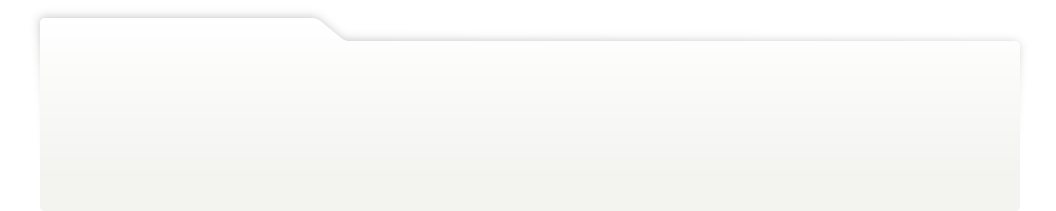
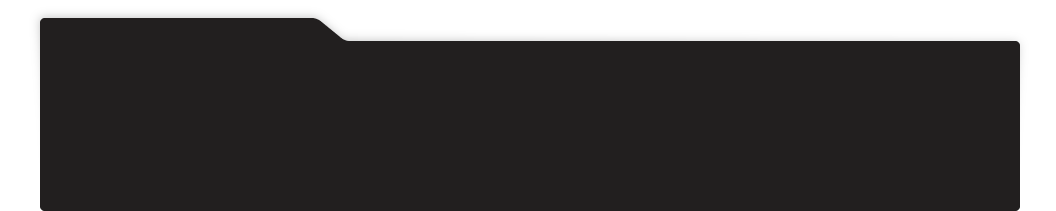
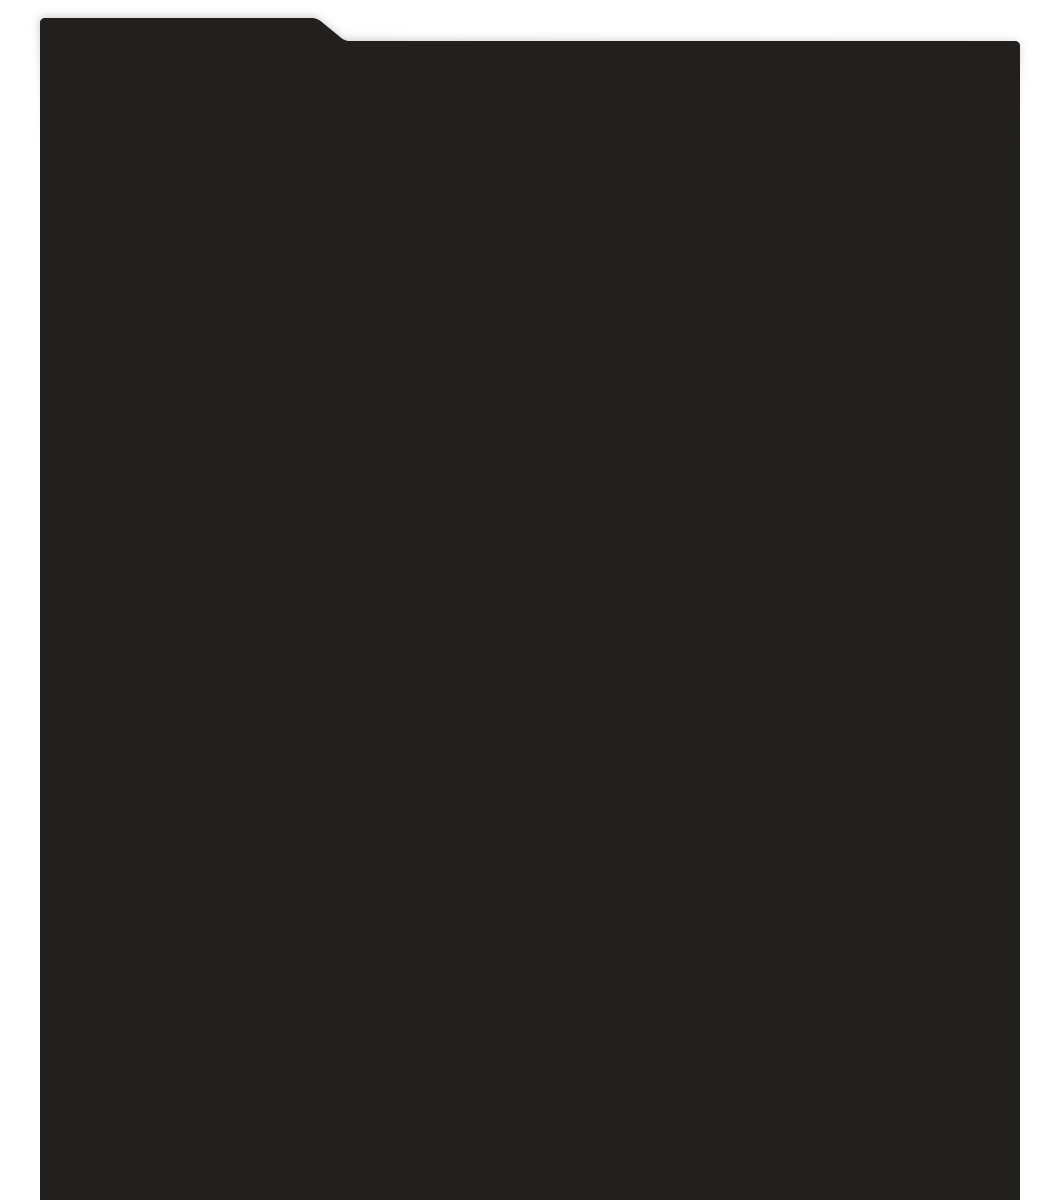
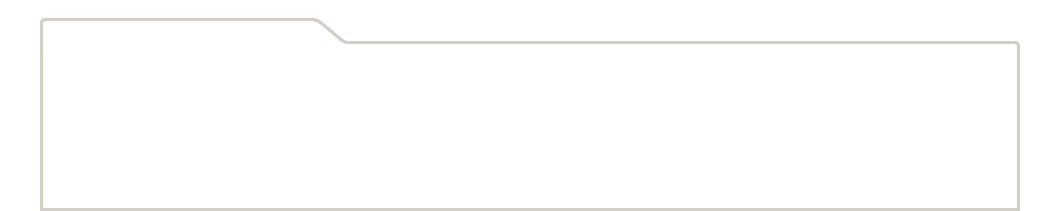
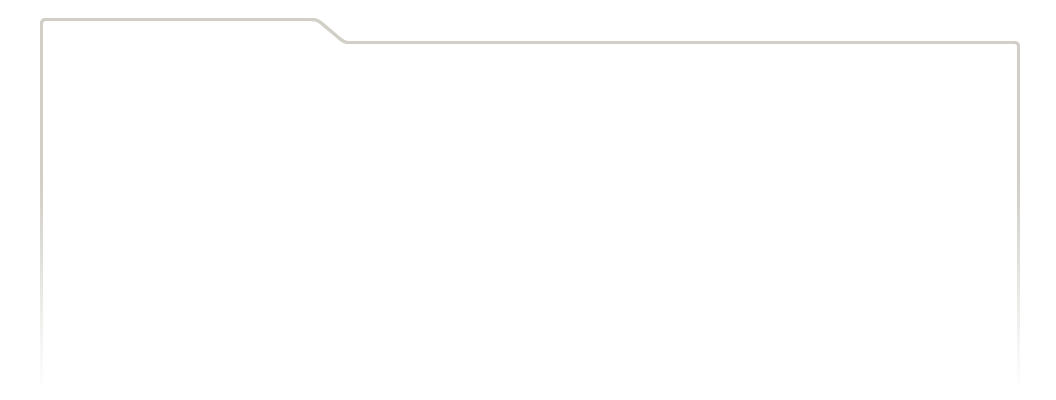
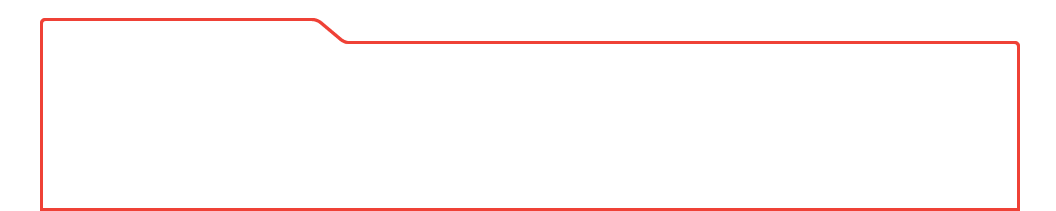
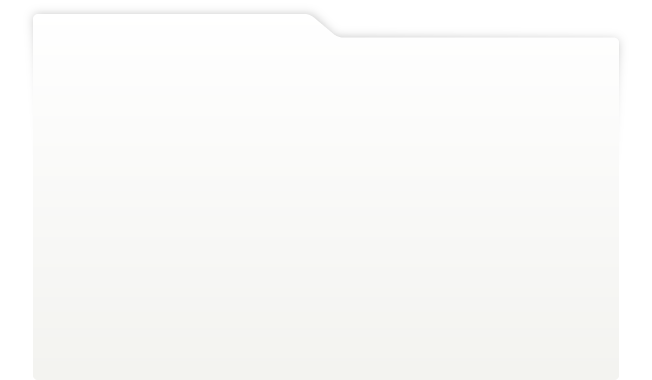
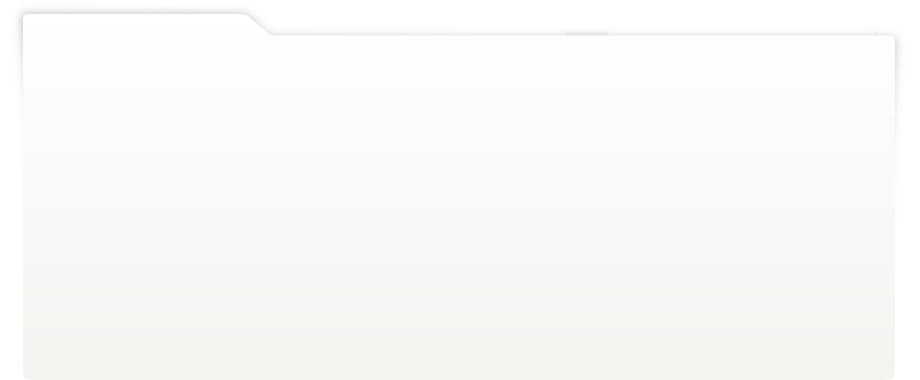
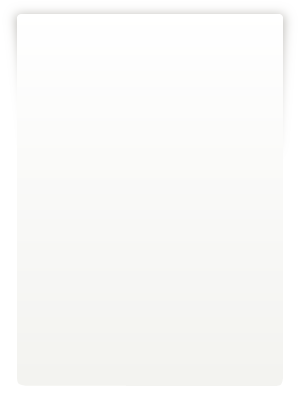
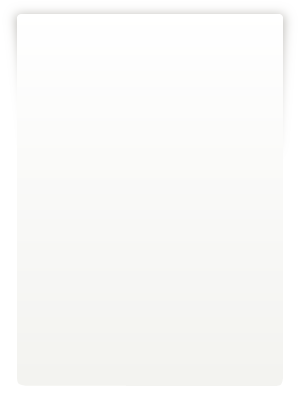
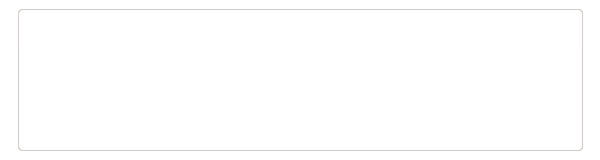
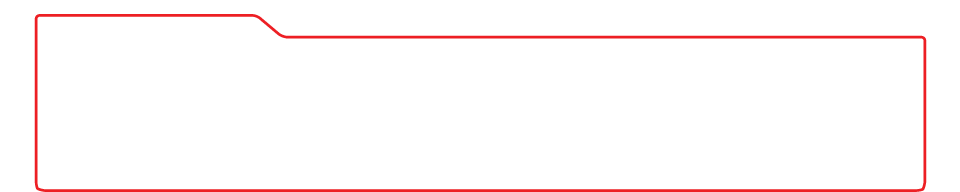
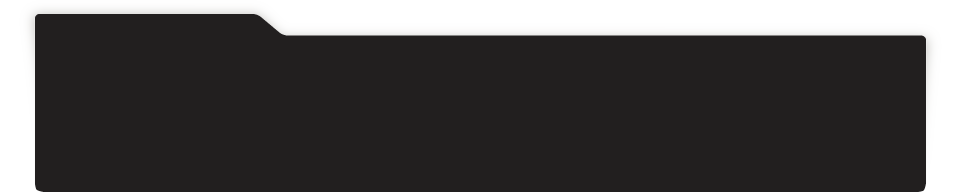
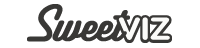
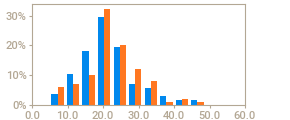
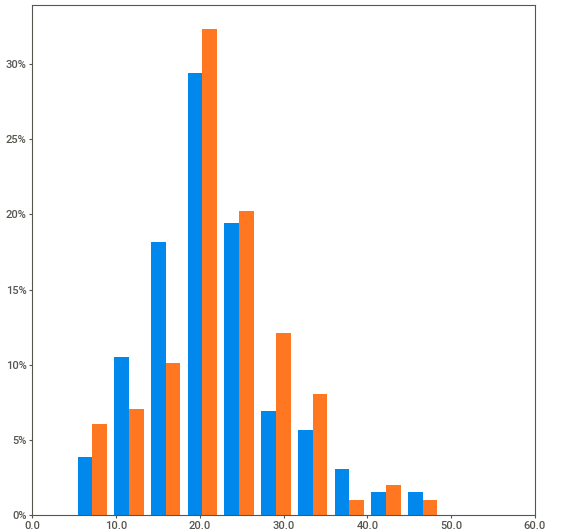
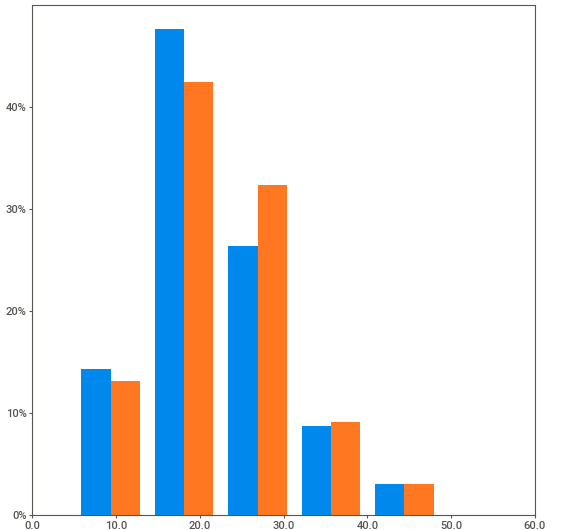
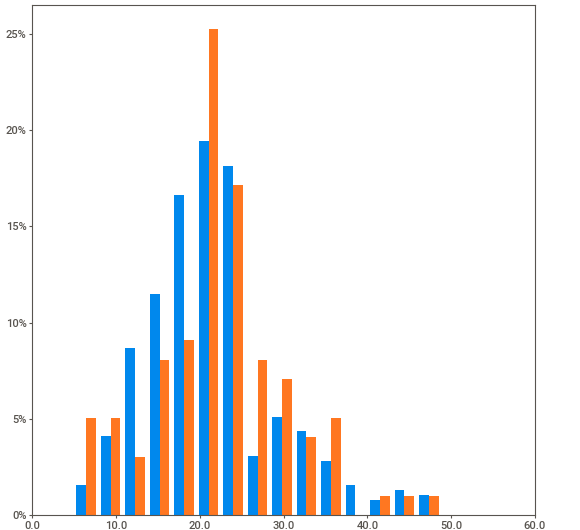
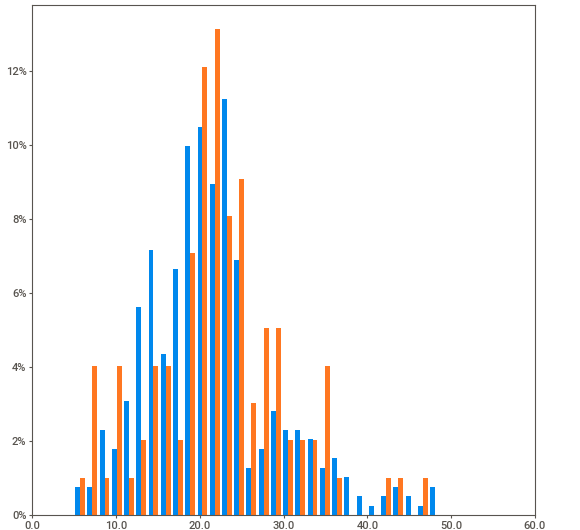
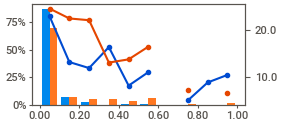
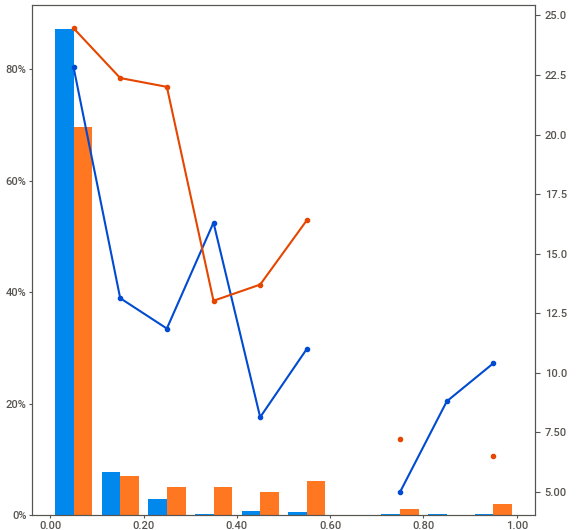
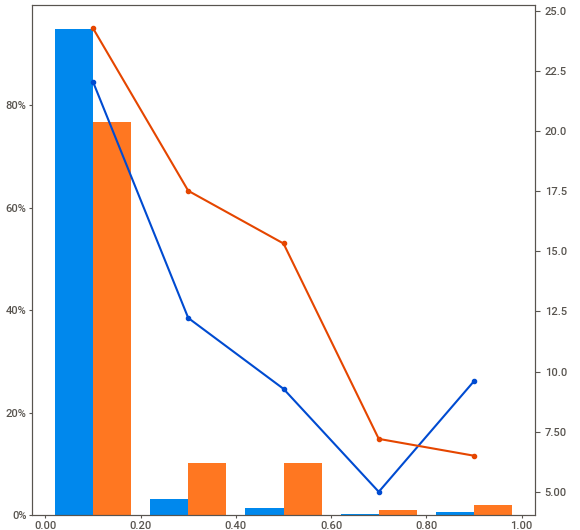
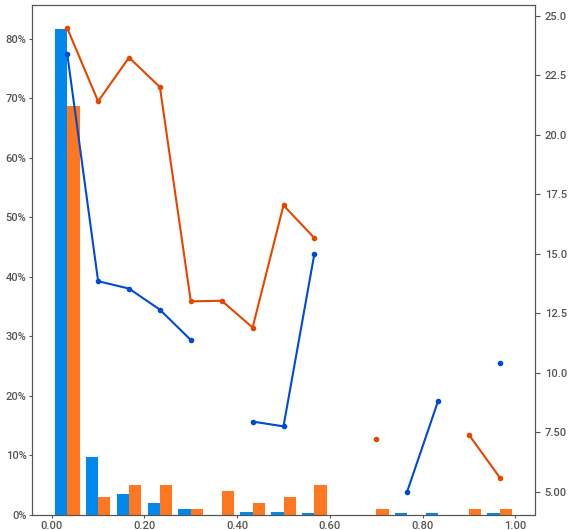
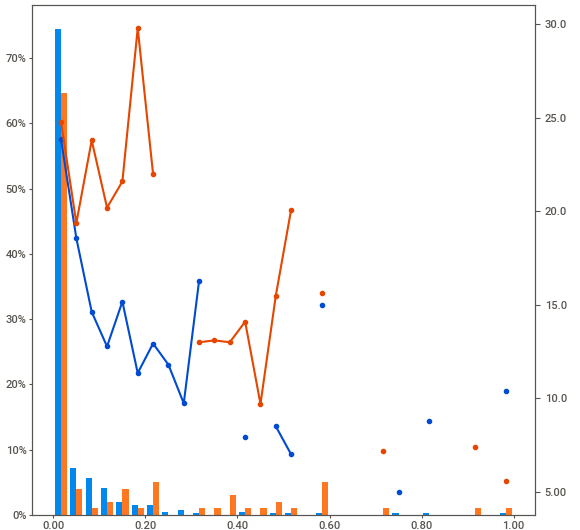
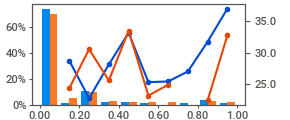
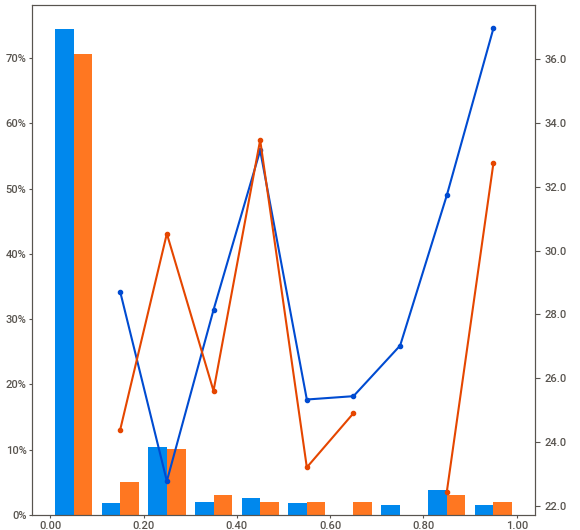
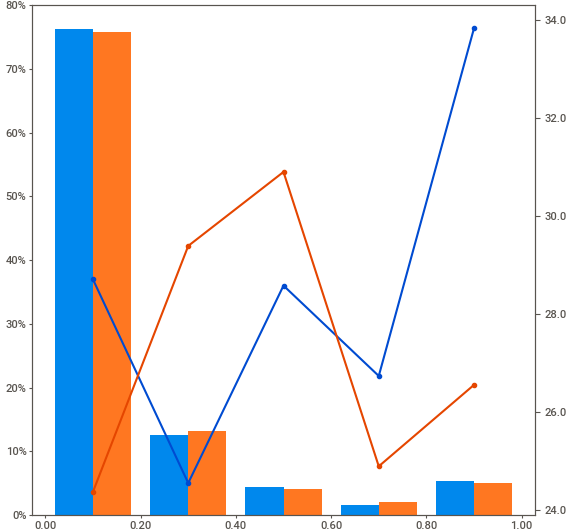
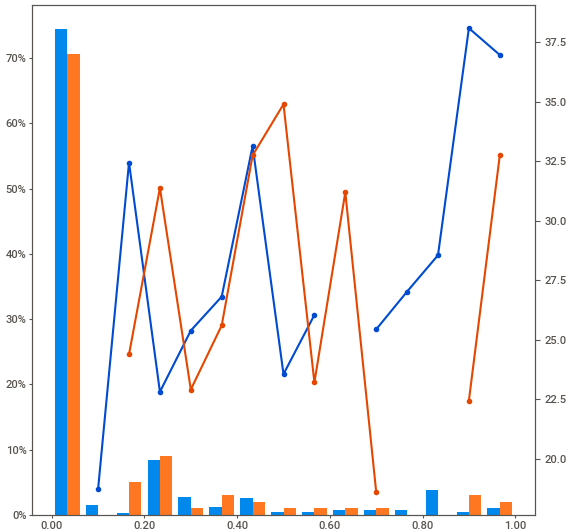
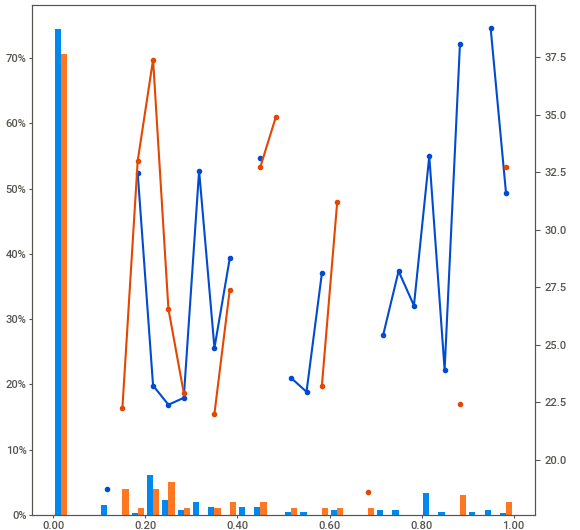
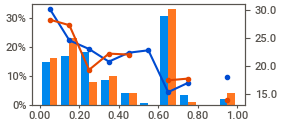
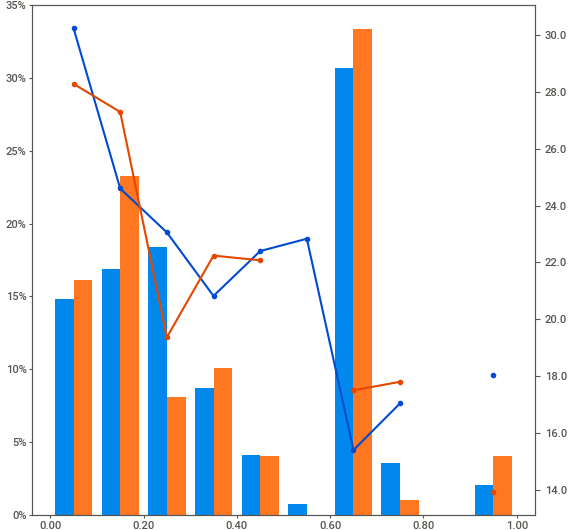
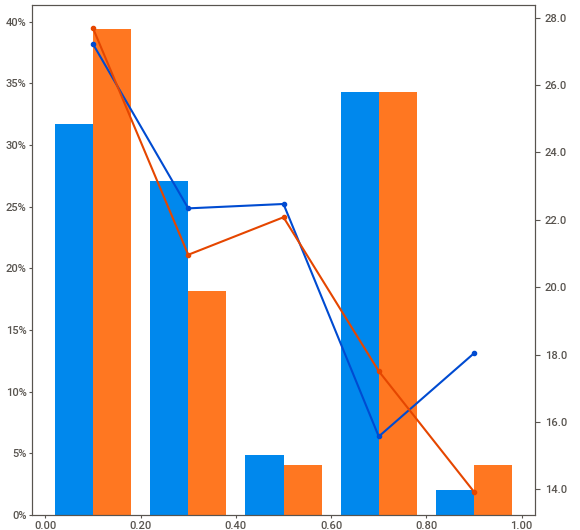
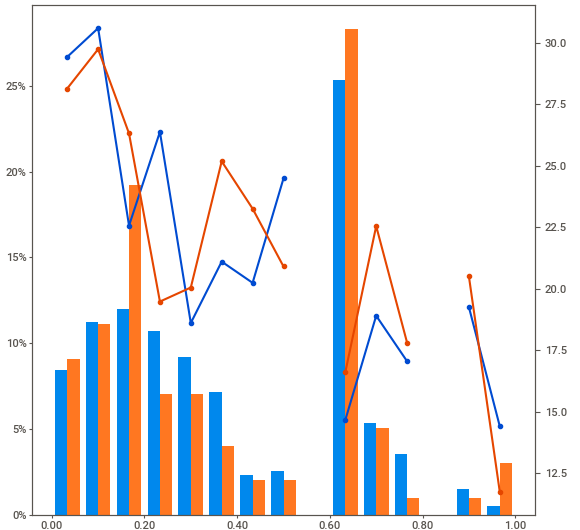
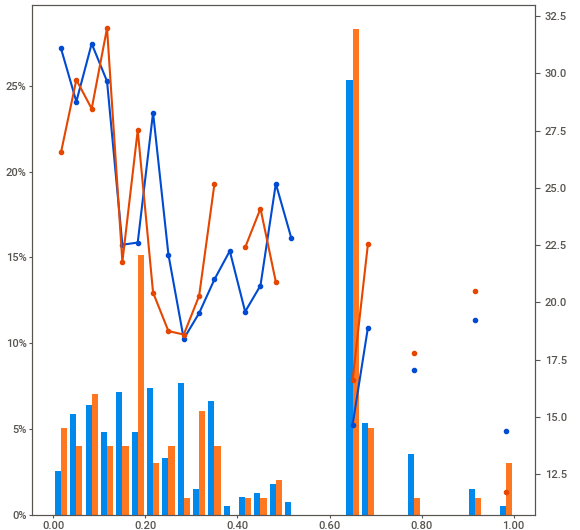
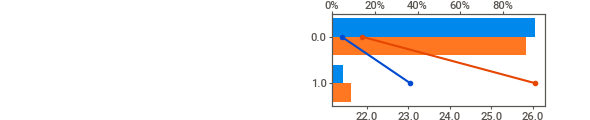
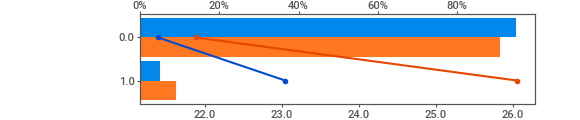
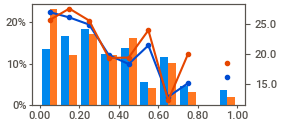
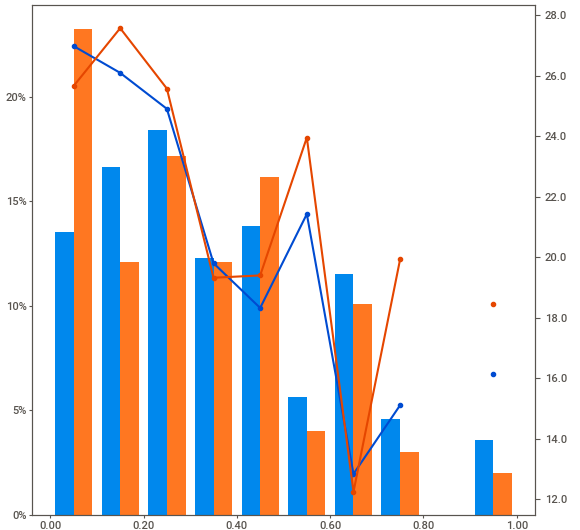
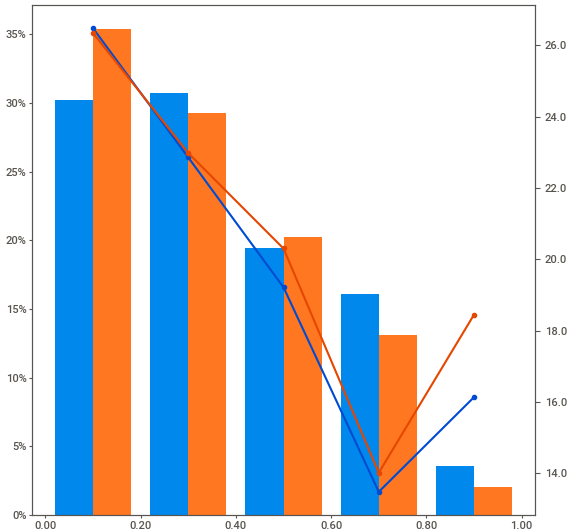
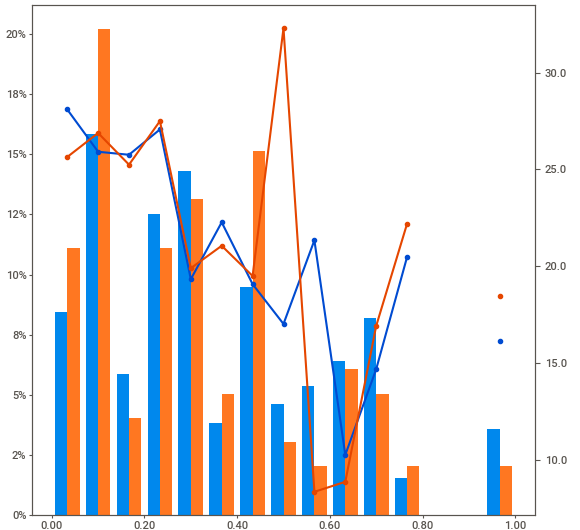
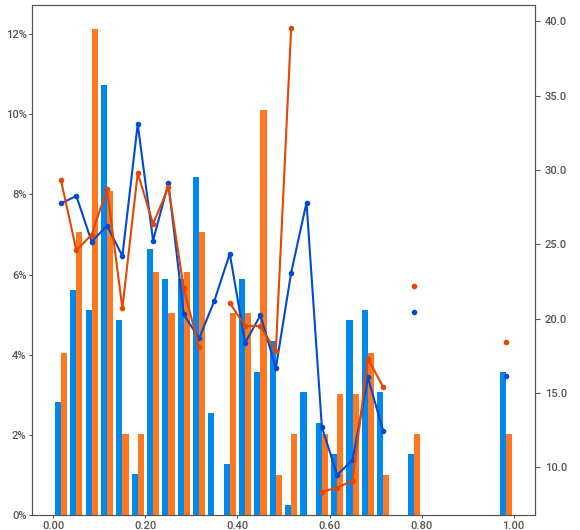
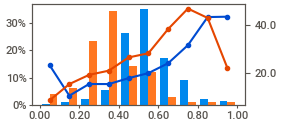
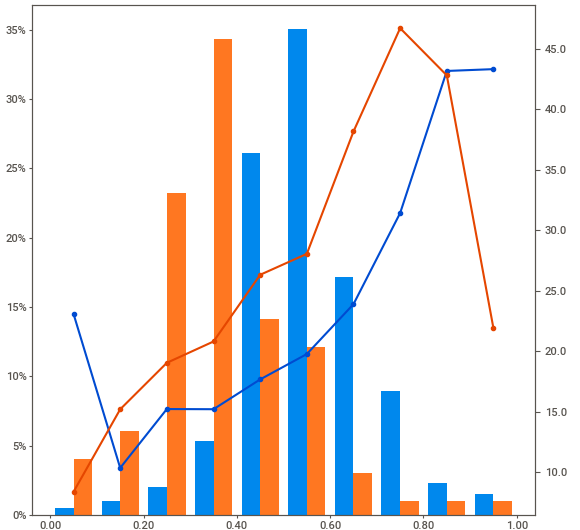
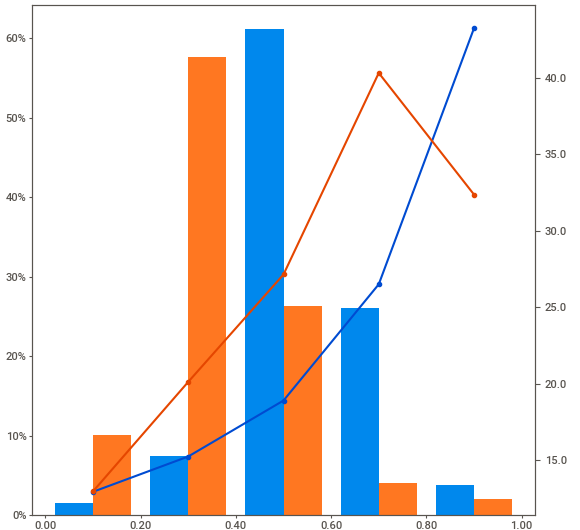
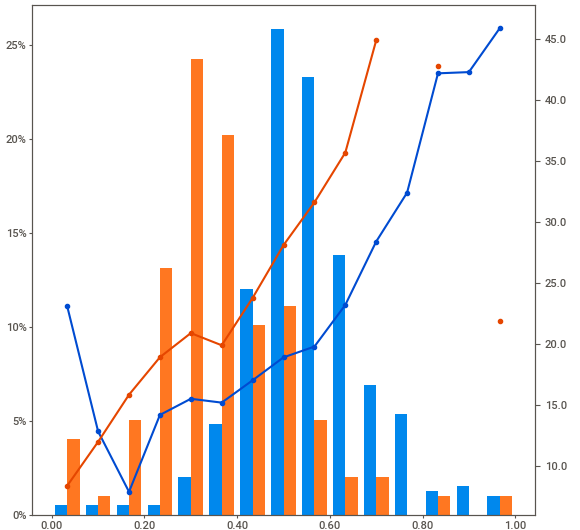
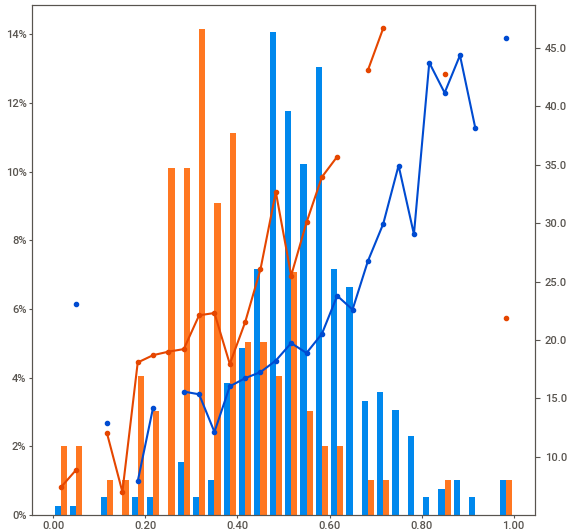
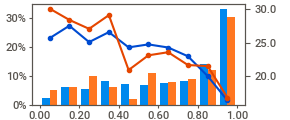
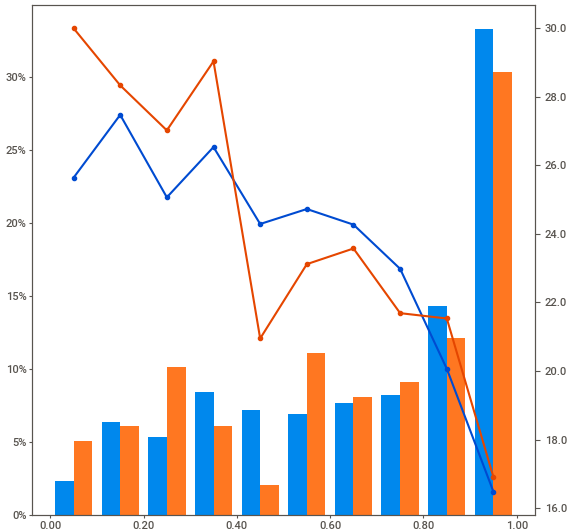
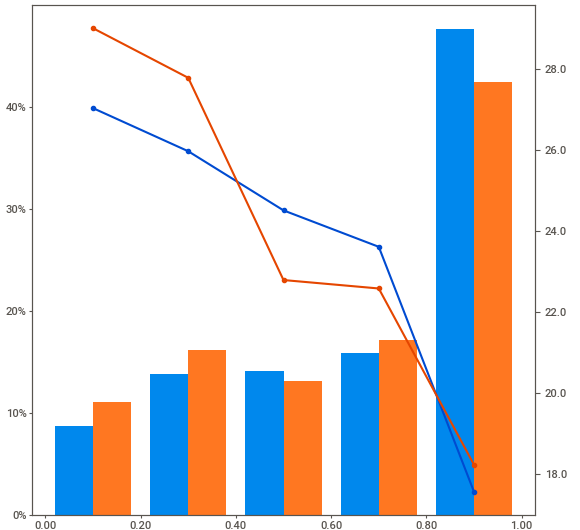
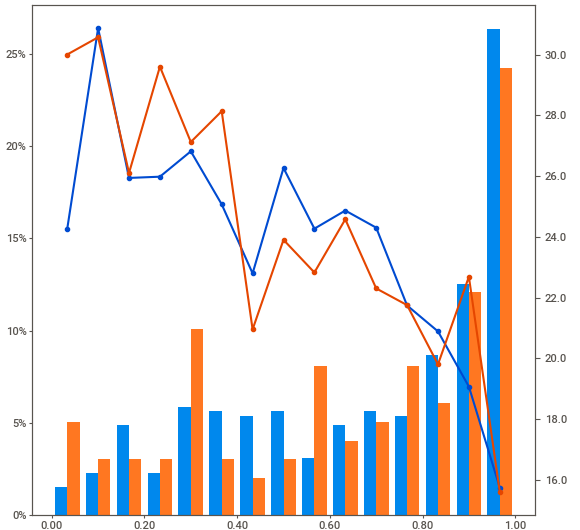
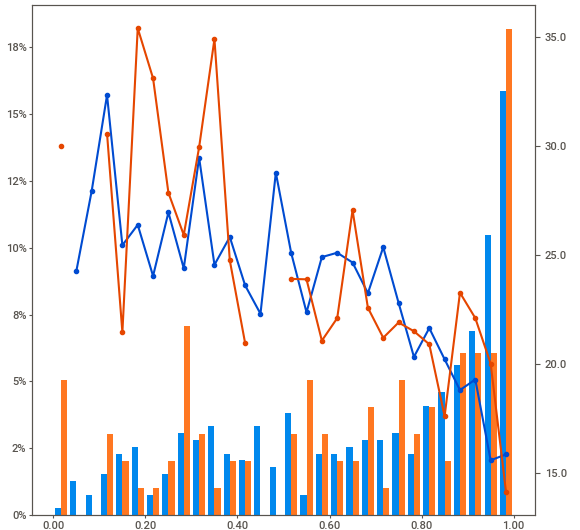
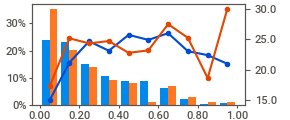
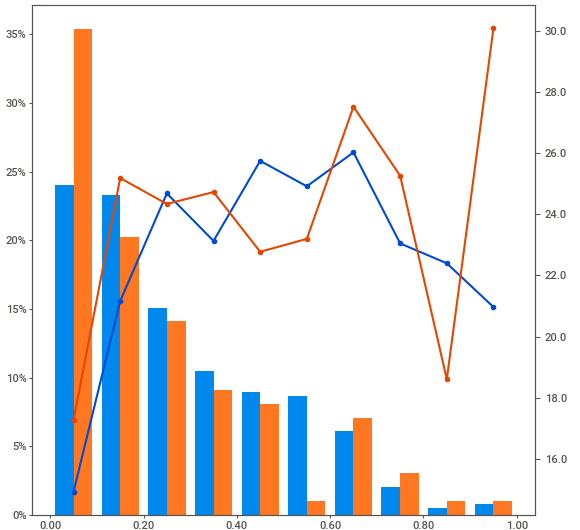
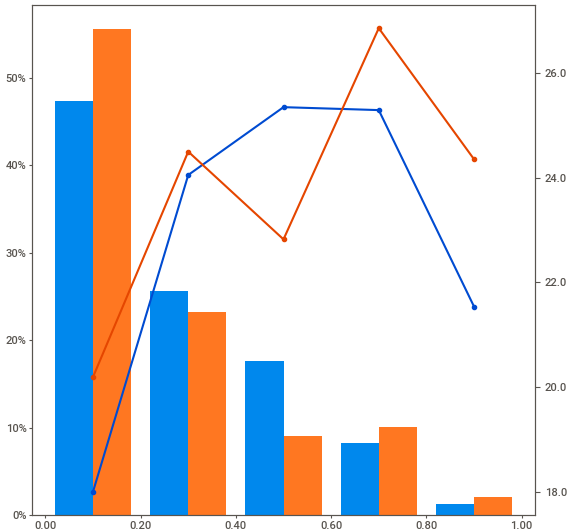
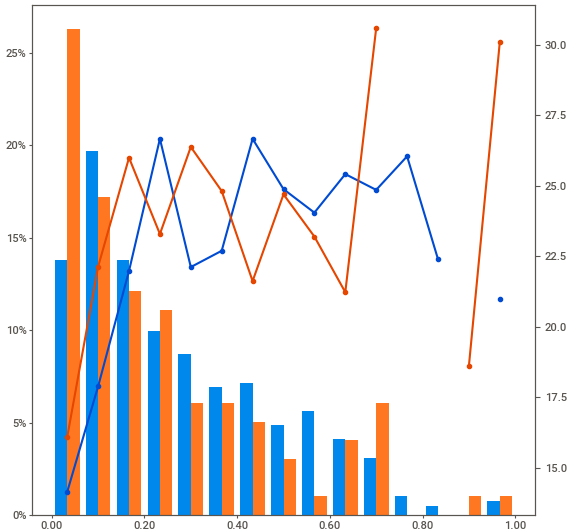
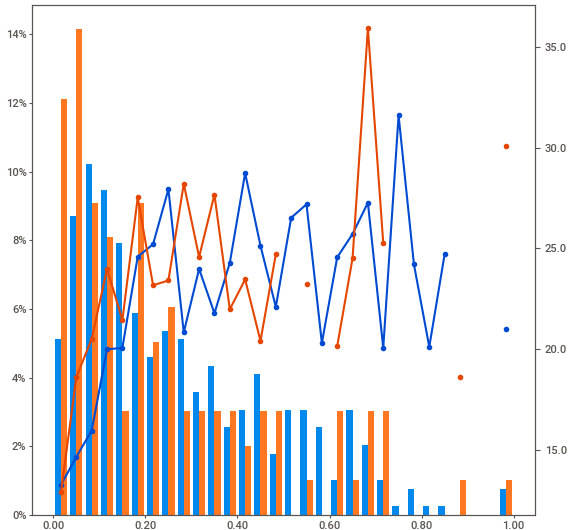
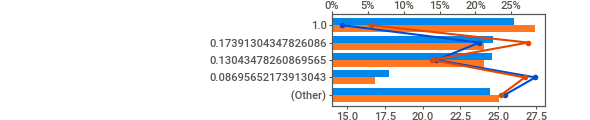
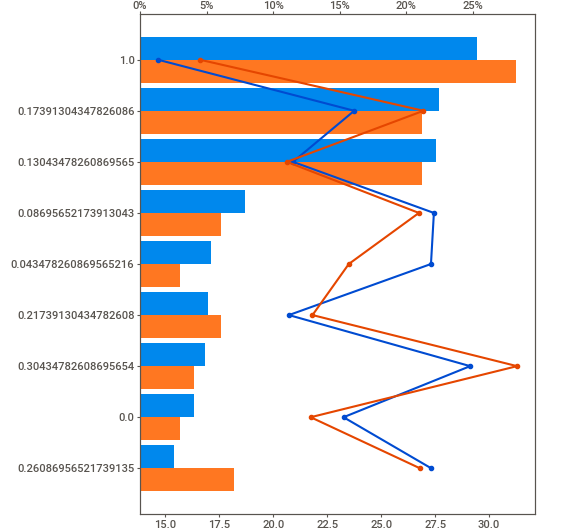
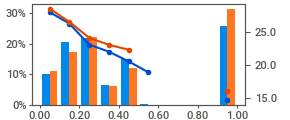
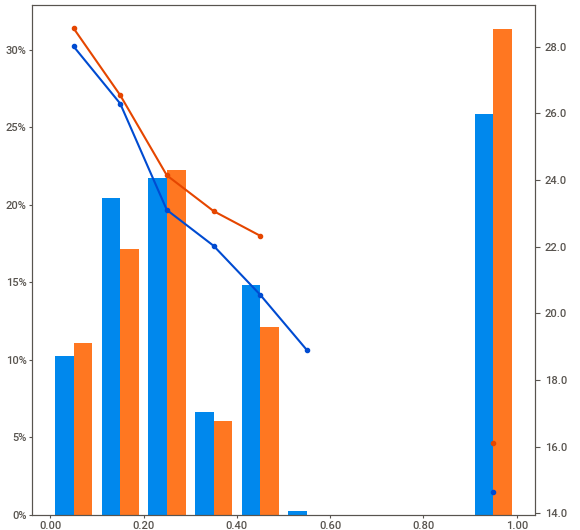
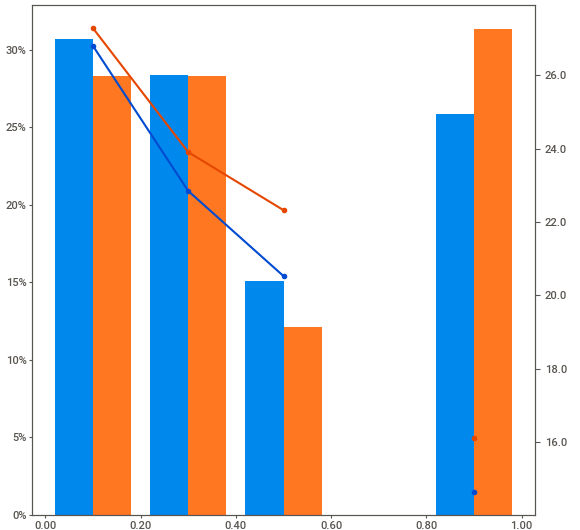
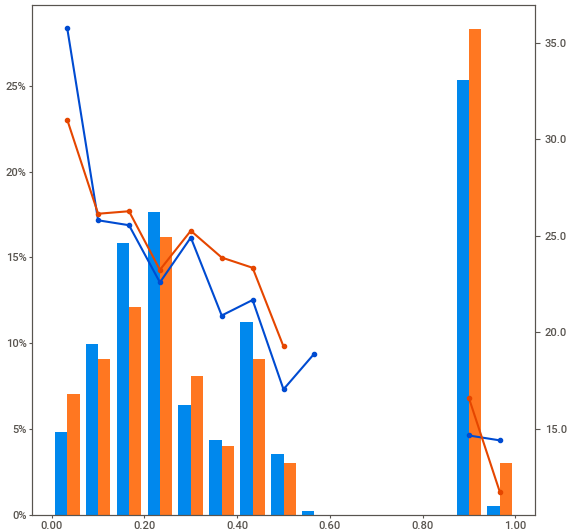
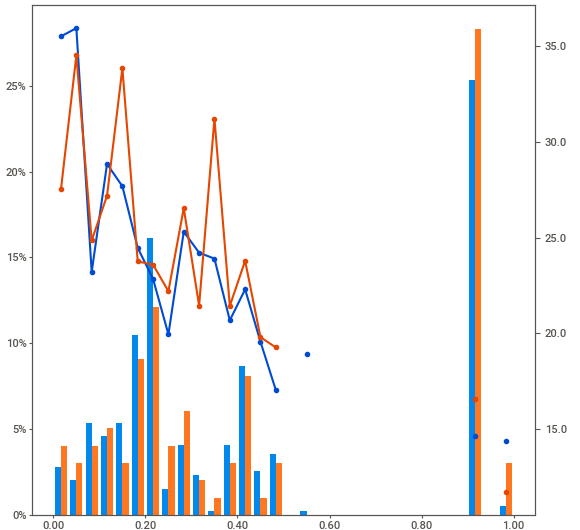
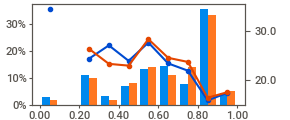
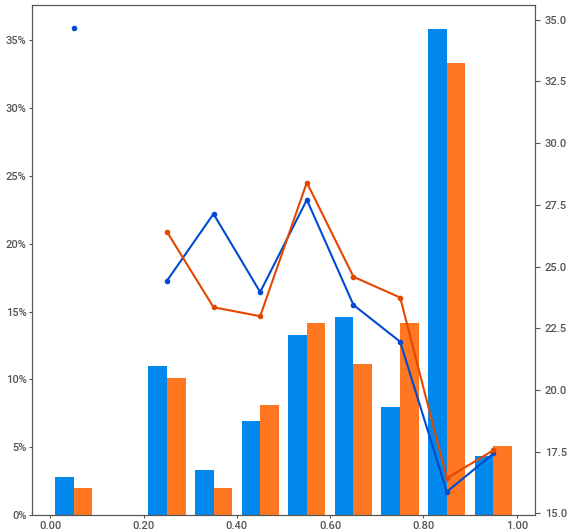
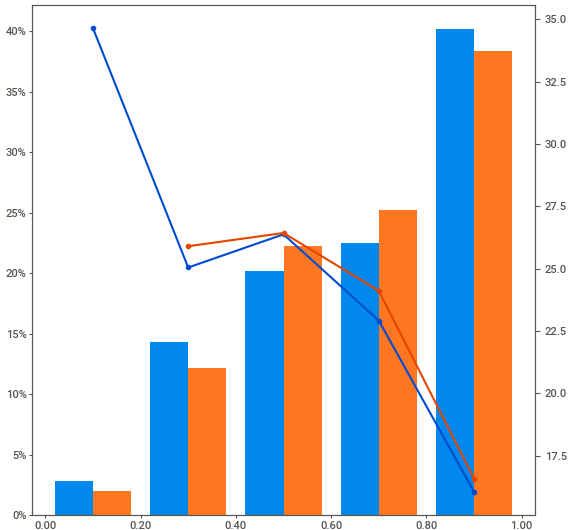
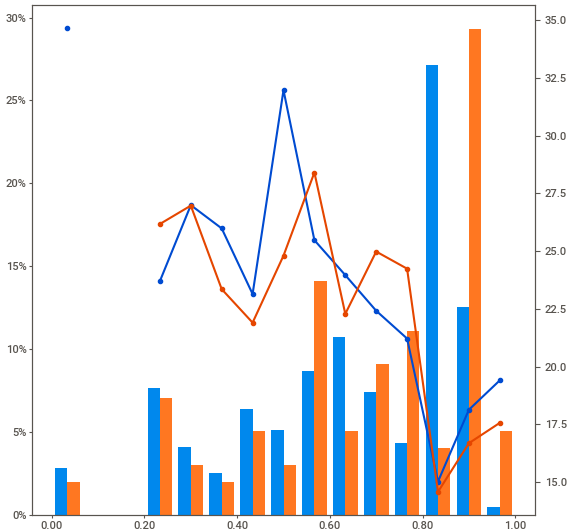
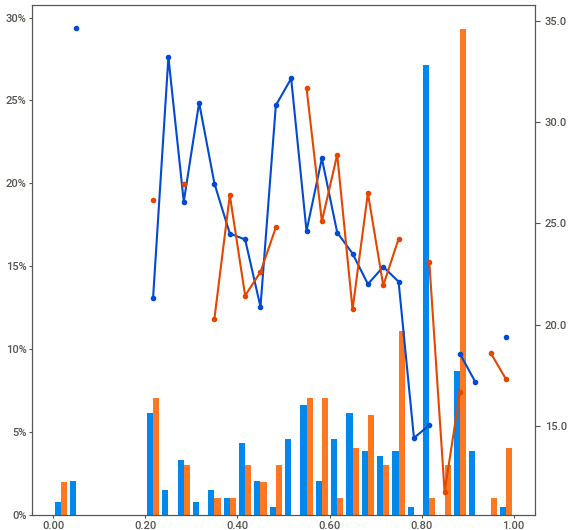
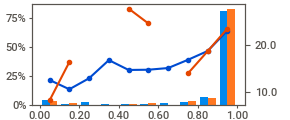
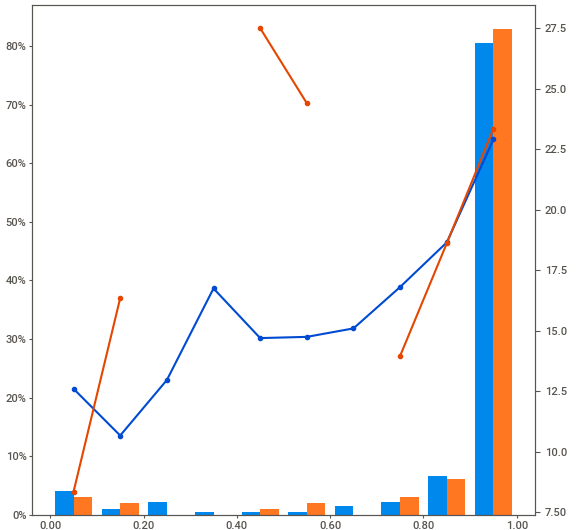
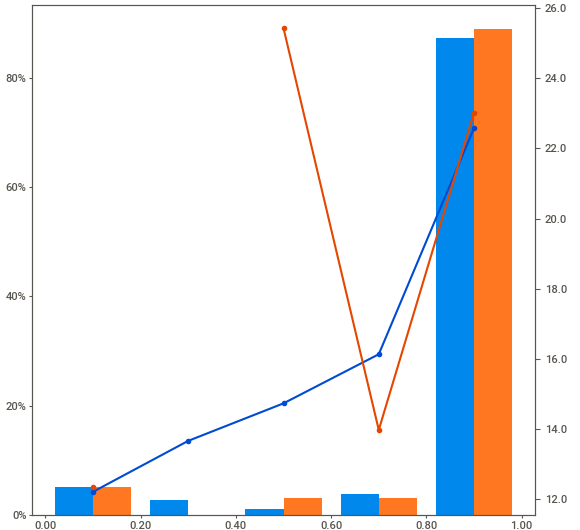
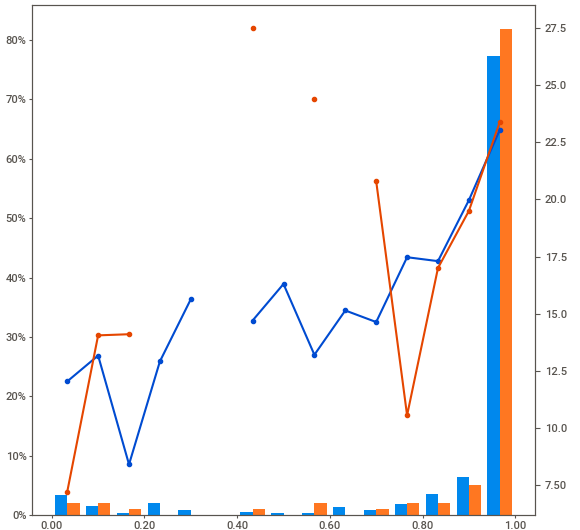
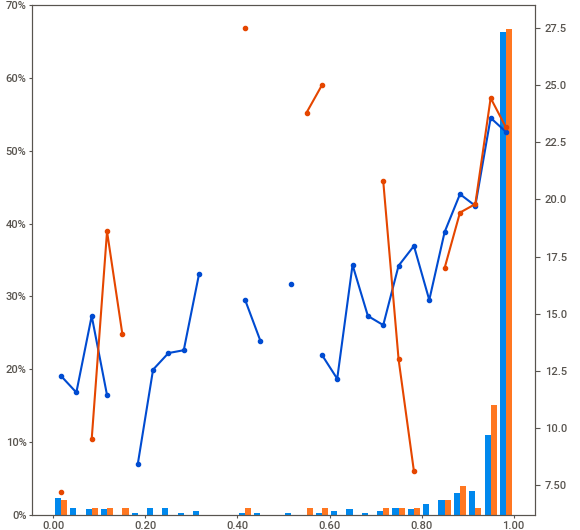
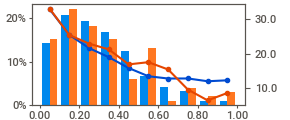
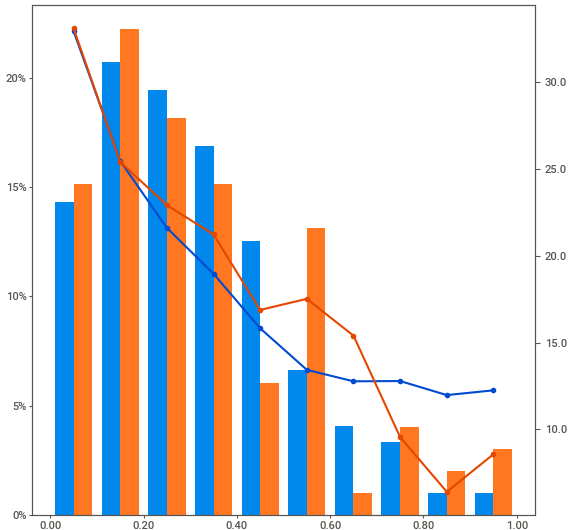
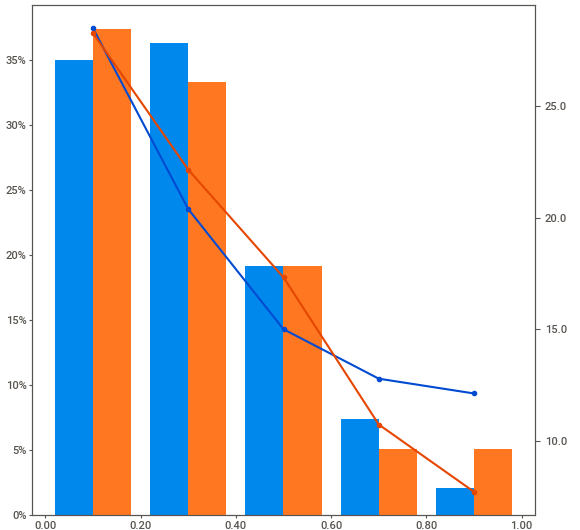
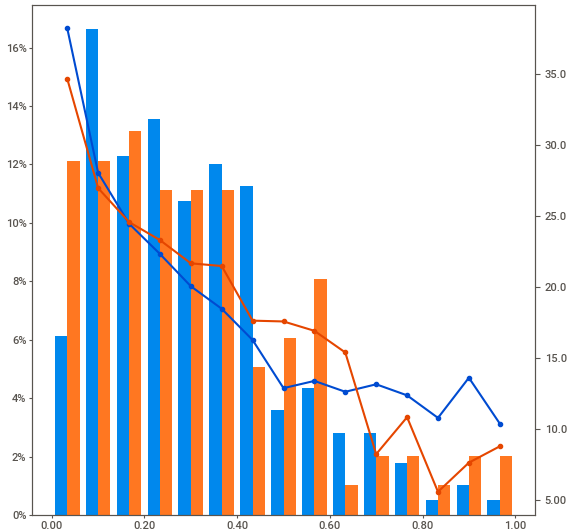
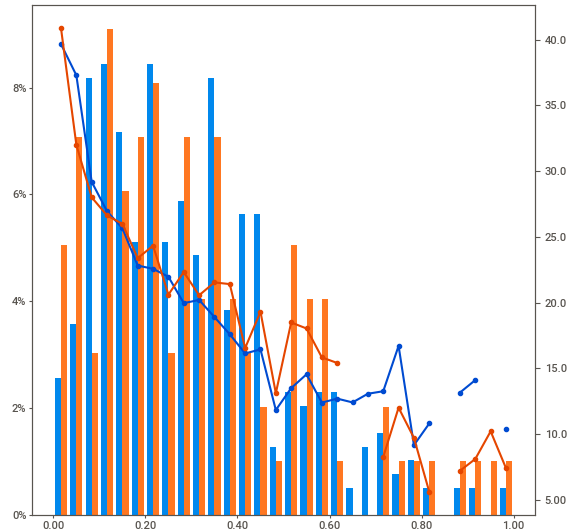
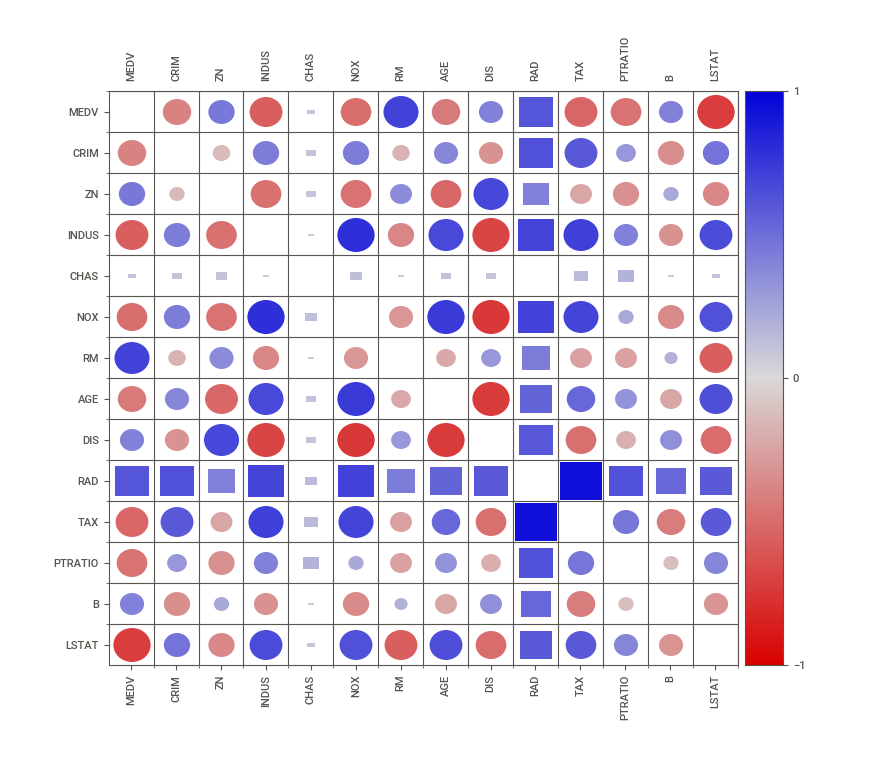
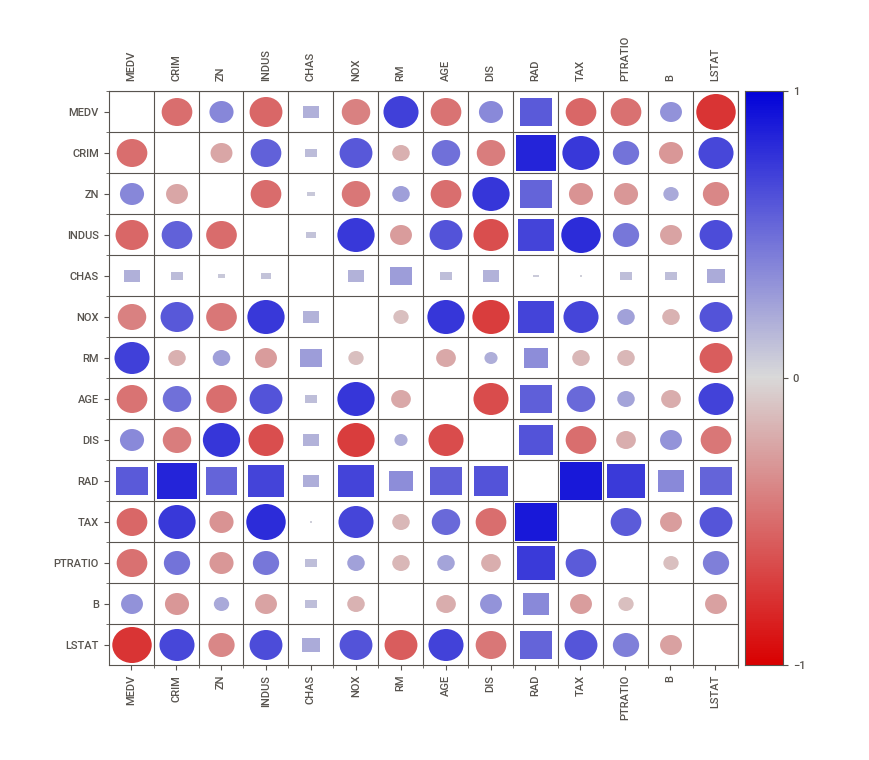

In [161]:
compare_report.show_html(filepath='.\\Analysis\\Compare_report.html')
compare_report.show_notebook()

## Selecting Features 

Based on the analysis made the starting model will begin with the following features as predictors:

1. `LSTAT`
2. `RM` 
3. `PTRATIO`
4. `INDUS` 
5. `CRIM`
6. `AGE`
7. `RAD`

This choice might be changed based on the performance of the model.

In [162]:
# Isolating the chosen features
#TODO Make this in a more optimized way
selected_features = ['CRIM','INDUS','RM','AGE','RAD','PTRATIO','LSTAT'] 
x_train = x[selected_features]
y_train = pd.DataFrame(x['MEDV'],columns=['MEDV'])
x_test = x2[selected_features]
y_test = pd.DataFrame(x2['MEDV'],columns=['MEDV'])
y_test

,MEDV
0,7.2
1,18.8
2,19.0
3,27.0
4,22.2
...,...
96,36.0
97,21.9
98,24.1
100,26.7


## Formatting the Data

TensorFlow doesn't load a pandas DataFrame natively, so some transformation is needed

In [163]:
# Transforming the training and test datasets
training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(x_train.values, tf.float32),
            tf.cast(y_train.values, tf.float32)
        )
    )
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(x_test.values,tf.float32),
            tf.cast(y_test.values,tf.float32)
        )
    )
)

training_dataset, test_dataset

(<TensorSliceDataset shapes: ((7,), (1,)), types: (tf.float32, tf.float32)>,
 <TensorSliceDataset shapes: ((7,), (1,)), types: (tf.float32, tf.float32)>)

## Create First Model

We'll start with a simple model and slowly adding and changing it to improve the results

In [164]:
#Setting random seed to guarantee reproducibility
tf.random.set_seed(42)

# Create model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
])

#Compile model
model.compile(
    loss = tf.losses.mae,
    optimizer = tf.optimizers.SGD(),
    metrics = tf.metrics.mae
)

#Fit model

history = model.fit(training_dataset,epochs = 100)

Epoch 1/100
391/391 [==============================] - 0s 1ms/step - loss: 5.4088 - mean_absolute_error: 5.4088


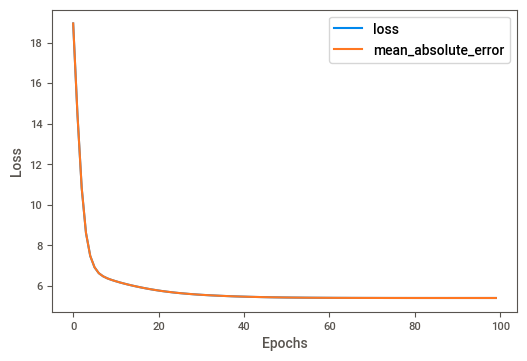

In [165]:
# Plotting Loss Curve
plt = pd.DataFrame(history.history).plot(xlabel = 'Epochs',ylabel = 'Loss')


In [166]:
# Evaluating on test data
model.evaluate(test_dataset)

99/99 [==============================] - 0s 868us/step - loss: 5.7220 - mean_absolute_error: 5.7220


[5.722031593322754, 5.72203254699707]

## Improving the Model

The first model seemed very promising, with a simple 1 neuron with 1 node it managed to achieve a MAE of 6.8. It still means that on average the model is $6,000 wrong, but still, given the complexity of our data and the simplicity of the first model it is a good starting point.

Over the next steps we'll be adding little changes to our model in order to evaluate and improve it`

### Model 2

In this model we'll try increasing the depth and width of our model in order to increase its ability to identify different features on the dataset.

In [167]:
# Plotting Loss Curve
plt = pd.DataFrame(history_3.history).plot(xlabel = 'Epochs',ylabel = 'Loss')


Epoch 1/100


  1/391 [..............................] - ETA: 1:07 - loss: 15.1000 - mean_absolute_error: 15.1000

 33/391 [=>............................] - ETA: 0s - loss: 18.0114 - mean_absolute_error: 18.0114  

 65/391 [===>..........................] - ETA: 0s - loss: 12.5871 - mean_absolute_error: 12.5871

 98/391 [======>.......................] - ETA: 0s - loss: 11.2727 - mean_absolute_error: 11.2727

130/391 [========>.....................] - ETA: 0s - loss: 10.4593 - mean_absolute_error: 10.4593



163/391 [===========>..................] - ETA: 0s - loss: 9.4451 - mean_absolute_error: 9.4451  



197/391 [==============>...............] - ETA: 0s - loss: 8.9569 - mean_absolute_error: 8.9569



229/391 [================>.............] - ETA: 0s - loss: 8.4571 - mean_absolute_error: 8.4571

261/391 [===================>..........] - ETA: 0s - loss: 8.1730 - mean_absolute_error: 8.1729

293/391 [=====================>........] - ETA: 0s - loss: 7.9070 - mean_absolute_error: 7.9070



326/391 [========================>.....] - ETA: 0s - loss: 7.7233 - mean_absolute_error: 7.7233



359/391 [==========================>...] - ETA: 0s - loss: 7.5851 - mean_absolute_error: 7.5851



391/391 [==============================] - ETA: 0s - loss: 7.4614 - mean_absolute_error: 7.4614

391/391 [==============================] - 1s 2ms/step - loss: 7.4614 - mean_absolute_error: 7.4614


Epoch 2/100
  1/391 [..............................] - ETA: 0s - loss: 7.0536 - mean_absolute_error: 7.0536

 33/391 [=>............................] - ETA: 0s - loss: 5.7968 - mean_absolute_error: 5.7968



 66/391 [====>.........................] - ETA: 0s - loss: 5.5062 - mean_absolute_error: 5.5062



 96/391 [======>.......................] - ETA: 0s - loss: 6.1742 - mean_absolute_error: 6.1742



128/391 [========>.....................] - ETA: 0s - loss: 6.3590 - mean_absolute_error: 6.3590



160/391 [===========>..................] - ETA: 0s - loss: 6.0883 - mean_absolute_error: 6.0883

193/391 [=============>................] - ETA: 0s - loss: 6.1058 - mean_absolute_error: 6.1058

226/391 [================>.............] - ETA: 0s - loss: 5.8304 - mean_absolute_error: 5.8304

259/391 [==================>...........] - ETA: 0s - loss: 5.9639 - mean_absolute_error: 5.9639



292/391 [=====================>........] - ETA: 0s - loss: 5.9273 - mean_absolute_error: 5.9273



325/391 [=======================>......] - ETA: 0s - loss: 5.9373 - mean_absolute_error: 5.9373



358/391 [==========================>...] - ETA: 0s - loss: 5.9611 - mean_absolute_error: 5.9611

391/391 [==============================] - ETA: 0s - loss: 5.9400 - mean_absolute_error: 5.9400

391/391 [==============================] - 1s 2ms/step - loss: 5.9400 - mean_absolute_error: 5.9400


Epoch 3/100
  1/391 [..............................] - ETA: 0s - loss: 5.6837 - mean_absolute_error: 5.6837



 34/391 [=>............................] - ETA: 0s - loss: 5.6980 - mean_absolute_error: 5.6980



 67/391 [====>.........................] - ETA: 0s - loss: 5.3970 - mean_absolute_error: 5.3970



100/391 [======>.......................] - ETA: 0s - loss: 6.2595 - mean_absolute_error: 6.2595

131/391 [=========>....................] - ETA: 0s - loss: 6.2691 - mean_absolute_error: 6.2691



162/391 [===========>..................] - ETA: 0s - loss: 5.9652 - mean_absolute_error: 5.9652



195/391 [=============>................] - ETA: 0s - loss: 5.9534 - mean_absolute_error: 5.9534



228/391 [================>.............] - ETA: 0s - loss: 5.7486 - mean_absolute_error: 5.7486



261/391 [===================>..........] - ETA: 0s - loss: 5.8415 - mean_absolute_error: 5.8415



293/391 [=====================>........] - ETA: 0s - loss: 5.8187 - mean_absolute_error: 5.8186



326/391 [========================>.....] - ETA: 0s - loss: 5.8414 - mean_absolute_error: 5.8414

359/391 [==========================>...] - ETA: 0s - loss: 5.8544 - mean_absolute_error: 5.8544

391/391 [==============================] - 1s 2ms/step - loss: 5.8421 - mean_absolute_error: 5.8421


Epoch 4/100
  1/391 [..............................] - ETA: 0s - loss: 5.1308 - mean_absolute_error: 5.1308



 34/391 [=>............................] - ETA: 0s - loss: 5.5128 - mean_absolute_error: 5.5128



 67/391 [====>.........................] - ETA: 0s - loss: 5.2702 - mean_absolute_error: 5.2702

100/391 [======>.......................] - ETA: 0s - loss: 6.1263 - mean_absolute_error: 6.1263

133/391 [=========>....................] - ETA: 0s - loss: 6.1561 - mean_absolute_error: 6.1561



166/391 [===========>..................] - ETA: 0s - loss: 5.8492 - mean_absolute_error: 5.8492



199/391 [==============>...............] - ETA: 0s - loss: 5.8235 - mean_absolute_error: 5.8235



231/391 [================>.............] - ETA: 0s - loss: 5.6942 - mean_absolute_error: 5.6942

264/391 [===================>..........] - ETA: 0s - loss: 5.7446 - mean_absolute_error: 5.7446

297/391 [=====================>........] - ETA: 0s - loss: 5.7035 - mean_absolute_error: 5.7035

329/391 [========================>.....] - ETA: 0s - loss: 5.7938 - mean_absolute_error: 5.7938



362/391 [==========================>...] - ETA: 0s - loss: 5.7675 - mean_absolute_error: 5.7675



391/391 [==============================] - 1s 2ms/step - loss: 5.7413 - mean_absolute_error: 5.7413


Epoch 5/100
  1/391 [..............................] - ETA: 0s - loss: 4.6958 - mean_absolute_error: 4.6958



 34/391 [=>............................] - ETA: 0s - loss: 5.5415 - mean_absolute_error: 5.5415



 66/391 [====>.........................] - ETA: 0s - loss: 5.2070 - mean_absolute_error: 5.2070



 99/391 [======>.......................] - ETA: 0s - loss: 6.0057 - mean_absolute_error: 6.0057

132/391 [=========>....................] - ETA: 0s - loss: 6.0837 - mean_absolute_error: 6.0837

165/391 [===========>..................] - ETA: 0s - loss: 5.8215 - mean_absolute_error: 5.8215



198/391 [==============>...............] - ETA: 0s - loss: 5.8006 - mean_absolute_error: 5.8006



231/391 [================>.............] - ETA: 0s - loss: 5.6394 - mean_absolute_error: 5.6394



264/391 [===================>..........] - ETA: 0s - loss: 5.7037 - mean_absolute_error: 5.7037

297/391 [=====================>........] - ETA: 0s - loss: 5.6659 - mean_absolute_error: 5.6659

330/391 [========================>.....] - ETA: 0s - loss: 5.7668 - mean_absolute_error: 5.7668

363/391 [==========================>...] - ETA: 0s - loss: 5.7502 - mean_absolute_error: 5.7502



391/391 [==============================] - 1s 2ms/step - loss: 5.6993 - mean_absolute_error: 5.6993


Epoch 6/100
  1/391 [..............................] - ETA: 0s - loss: 5.0201 - mean_absolute_error: 5.0201



 34/391 [=>............................] - ETA: 0s - loss: 5.4705 - mean_absolute_error: 5.4705



 67/391 [====>.........................] - ETA: 0s - loss: 5.2094 - mean_absolute_error: 5.2094



 99/391 [======>.......................] - ETA: 0s - loss: 5.9932 - mean_absolute_error: 5.9932

132/391 [=========>....................] - ETA: 0s - loss: 6.0462 - mean_absolute_error: 6.0462



165/391 [===========>..................] - ETA: 0s - loss: 5.7799 - mean_absolute_error: 5.7799



198/391 [==============>...............] - ETA: 0s - loss: 5.7564 - mean_absolute_error: 5.7564



231/391 [================>.............] - ETA: 0s - loss: 5.5958 - mean_absolute_error: 5.5958



264/391 [===================>..........] - ETA: 0s - loss: 5.6593 - mean_absolute_error: 5.6593

294/391 [=====================>........] - ETA: 0s - loss: 5.6614 - mean_absolute_error: 5.6614



318/391 [=======================>......] - ETA: 0s - loss: 5.6960 - mean_absolute_error: 5.6960



339/391 [=========================>....] - ETA: 0s - loss: 5.7310 - mean_absolute_error: 5.7310



362/391 [==========================>...] - ETA: 0s - loss: 5.6850 - mean_absolute_error: 5.6850



382/391 [============================>.] - ETA: 0s - loss: 5.6723 - mean_absolute_error: 5.6723

391/391 [==============================] - 1s 2ms/step - loss: 5.6601 - mean_absolute_error: 5.6601


Epoch 7/100
  1/391 [..............................] - ETA: 1s - loss: 4.8422 - mean_absolute_error: 4.8422

 24/391 [>.............................] - ETA: 0s - loss: 5.4404 - mean_absolute_error: 5.4404

 50/391 [==>...........................] - ETA: 0s - loss: 5.1138 - mean_absolute_error: 5.1138



 76/391 [====>.........................] - ETA: 0s - loss: 5.1555 - mean_absolute_error: 5.1555

102/391 [======>.......................] - ETA: 0s - loss: 6.0659 - mean_absolute_error: 6.0659

128/391 [========>.....................] - ETA: 0s - loss: 6.0253 - mean_absolute_error: 6.0253



154/391 [==========>...................] - ETA: 0s - loss: 5.8581 - mean_absolute_error: 5.8581



181/391 [============>.................] - ETA: 0s - loss: 5.7048 - mean_absolute_error: 5.7048

209/391 [===============>..............] - ETA: 0s - loss: 5.6008 - mean_absolute_error: 5.6008

242/391 [=================>............] - ETA: 0s - loss: 5.5886 - mean_absolute_error: 5.5886

275/391 [====================>.........] - ETA: 0s - loss: 5.6395 - mean_absolute_error: 5.6395



308/391 [======================>.......] - ETA: 0s - loss: 5.6653 - mean_absolute_error: 5.6653



342/391 [=========================>....] - ETA: 0s - loss: 5.7013 - mean_absolute_error: 5.7013



375/391 [===========================>..] - ETA: 0s - loss: 5.6793 - mean_absolute_error: 5.6793



391/391 [==============================] - 1s 2ms/step - loss: 5.6538 - mean_absolute_error: 5.6538


Epoch 8/100
  1/391 [..............................] - ETA: 0s - loss: 4.9845 - mean_absolute_error: 4.9845



 33/391 [=>............................] - ETA: 0s - loss: 5.4655 - mean_absolute_error: 5.4655

 66/391 [====>.........................] - ETA: 0s - loss: 5.1310 - mean_absolute_error: 5.1310

 99/391 [======>.......................] - ETA: 0s - loss: 5.9693 - mean_absolute_error: 5.9693



132/391 [=========>....................] - ETA: 0s - loss: 6.0245 - mean_absolute_error: 6.0245



165/391 [===========>..................] - ETA: 0s - loss: 5.7600 - mean_absolute_error: 5.7600



197/391 [==============>...............] - ETA: 0s - loss: 5.7455 - mean_absolute_error: 5.7455



230/391 [================>.............] - ETA: 0s - loss: 5.5892 - mean_absolute_error: 5.5892



263/391 [===================>..........] - ETA: 0s - loss: 5.6544 - mean_absolute_error: 5.6544

295/391 [=====================>........] - ETA: 0s - loss: 5.6484 - mean_absolute_error: 5.6484

328/391 [========================>.....] - ETA: 0s - loss: 5.6833 - mean_absolute_error: 5.6833

361/391 [==========================>...] - ETA: 0s - loss: 5.6661 - mean_absolute_error: 5.6661



391/391 [==============================] - 1s 2ms/step - loss: 5.6477 - mean_absolute_error: 5.6476


Epoch 9/100
  1/391 [..............................] - ETA: 0s - loss: 4.6442 - mean_absolute_error: 4.6442



 34/391 [=>............................] - ETA: 0s - loss: 5.3799 - mean_absolute_error: 5.3799

 67/391 [====>.........................] - ETA: 0s - loss: 5.1591 - mean_absolute_error: 5.1591

100/391 [======>.......................] - ETA: 0s - loss: 6.0289 - mean_absolute_error: 6.0289

132/391 [=========>....................] - ETA: 0s - loss: 6.0276 - mean_absolute_error: 6.0276



164/391 [===========>..................] - ETA: 0s - loss: 5.7308 - mean_absolute_error: 5.7308



196/391 [==============>...............] - ETA: 0s - loss: 5.7251 - mean_absolute_error: 5.7251

223/391 [================>.............] - ETA: 0s - loss: 5.5234 - mean_absolute_error: 5.5234

249/391 [==================>...........] - ETA: 0s - loss: 5.5850 - mean_absolute_error: 5.5850

274/391 [====================>.........] - ETA: 0s - loss: 5.5867 - mean_absolute_error: 5.5867



300/391 [======================>.......] - ETA: 0s - loss: 5.6357 - mean_absolute_error: 5.6357



326/391 [========================>.....] - ETA: 0s - loss: 5.6486 - mean_absolute_error: 5.6486



356/391 [==========================>...] - ETA: 0s - loss: 5.6753 - mean_absolute_error: 5.6753

389/391 [============================>.] - ETA: 0s - loss: 5.6400 - mean_absolute_error: 5.6400

391/391 [==============================] - 1s 2ms/step - loss: 5.6371 - mean_absolute_error: 5.6371


Epoch 10/100
  1/391 [..............................] - ETA: 1s - loss: 4.9264 - mean_absolute_error: 4.9264



 33/391 [=>............................] - ETA: 0s - loss: 5.4348 - mean_absolute_error: 5.4348

 64/391 [===>..........................] - ETA: 0s - loss: 5.1450 - mean_absolute_error: 5.1450

 92/391 [======>.......................] - ETA: 0s - loss: 5.7973 - mean_absolute_error: 5.7973

120/391 [========>.....................] - ETA: 0s - loss: 5.9831 - mean_absolute_error: 5.9831



146/391 [==========>...................] - ETA: 0s - loss: 5.8785 - mean_absolute_error: 5.8785



173/391 [============>.................] - ETA: 0s - loss: 5.6699 - mean_absolute_error: 5.6699



199/391 [==============>...............] - ETA: 0s - loss: 5.6908 - mean_absolute_error: 5.6908

225/391 [================>.............] - ETA: 0s - loss: 5.4877 - mean_absolute_error: 5.4877

252/391 [==================>...........] - ETA: 0s - loss: 5.5262 - mean_absolute_error: 5.5262



280/391 [====================>.........] - ETA: 0s - loss: 5.6342 - mean_absolute_error: 5.6342



308/391 [======================>.......] - ETA: 0s - loss: 5.6329 - mean_absolute_error: 5.6329



334/391 [========================>.....] - ETA: 0s - loss: 5.6691 - mean_absolute_error: 5.6691

363/391 [==========================>...] - ETA: 0s - loss: 5.6760 - mean_absolute_error: 5.6760

391/391 [==============================] - ETA: 0s - loss: 5.6206 - mean_absolute_error: 5.6206

391/391 [==============================] - 1s 2ms/step - loss: 5.6206 - mean_absolute_error: 5.6206


Epoch 11/100
  1/391 [..............................] - ETA: 0s - loss: 4.9752 - mean_absolute_error: 4.9752



 28/391 [=>............................] - ETA: 0s - loss: 5.4710 - mean_absolute_error: 5.4710



 55/391 [===>..........................] - ETA: 0s - loss: 5.0892 - mean_absolute_error: 5.0892

 83/391 [=====>........................] - ETA: 0s - loss: 5.3186 - mean_absolute_error: 5.3186

110/391 [=======>......................] - ETA: 0s - loss: 5.8667 - mean_absolute_error: 5.8667



137/391 [=========>....................] - ETA: 0s - loss: 6.0024 - mean_absolute_error: 6.0024



165/391 [===========>..................] - ETA: 0s - loss: 5.7427 - mean_absolute_error: 5.7427



193/391 [=============>................] - ETA: 0s - loss: 5.7528 - mean_absolute_error: 5.7528

221/391 [===============>..............] - ETA: 0s - loss: 5.5197 - mean_absolute_error: 5.5197



249/391 [==================>...........] - ETA: 0s - loss: 5.5680 - mean_absolute_error: 5.5680

277/391 [====================>.........] - ETA: 0s - loss: 5.6050 - mean_absolute_error: 5.6050



305/391 [======================>.......] - ETA: 0s - loss: 5.6390 - mean_absolute_error: 5.6390



332/391 [========================>.....] - ETA: 0s - loss: 5.6761 - mean_absolute_error: 5.6761



359/391 [==========================>...] - ETA: 0s - loss: 5.6432 - mean_absolute_error: 5.6432

387/391 [============================>.] - ETA: 0s - loss: 5.6367 - mean_absolute_error: 5.6367

391/391 [==============================] - 1s 2ms/step - loss: 5.6248 - mean_absolute_error: 5.6248


Epoch 12/100
  1/391 [..............................] - ETA: 1s - loss: 4.6977 - mean_absolute_error: 4.6977

 28/391 [=>............................] - ETA: 0s - loss: 5.4915 - mean_absolute_error: 5.4915

 55/391 [===>..........................] - ETA: 0s - loss: 5.0993 - mean_absolute_error: 5.0993



 83/391 [=====>........................] - ETA: 0s - loss: 5.3358 - mean_absolute_error: 5.3358



112/391 [=======>......................] - ETA: 0s - loss: 5.9219 - mean_absolute_error: 5.9219

140/391 [=========>....................] - ETA: 0s - loss: 5.9804 - mean_absolute_error: 5.9804

167/391 [===========>..................] - ETA: 0s - loss: 5.7226 - mean_absolute_error: 5.7226

194/391 [=============>................] - ETA: 0s - loss: 5.7433 - mean_absolute_error: 5.7433



222/391 [================>.............] - ETA: 0s - loss: 5.5322 - mean_absolute_error: 5.5322



250/391 [==================>...........] - ETA: 0s - loss: 5.5587 - mean_absolute_error: 5.5587



277/391 [====================>.........] - ETA: 0s - loss: 5.6092 - mean_absolute_error: 5.6092

304/391 [======================>.......] - ETA: 0s - loss: 5.6476 - mean_absolute_error: 5.6476

331/391 [========================>.....] - ETA: 0s - loss: 5.6884 - mean_absolute_error: 5.6884



359/391 [==========================>...] - ETA: 0s - loss: 5.6428 - mean_absolute_error: 5.6428



386/391 [============================>.] - ETA: 0s - loss: 5.6447 - mean_absolute_error: 5.6447

391/391 [==============================] - 1s 2ms/step - loss: 5.6220 - mean_absolute_error: 5.6220


Epoch 13/100
  1/391 [..............................] - ETA: 1s - loss: 4.6779 - mean_absolute_error: 4.6779

 30/391 [=>............................] - ETA: 0s - loss: 5.2619 - mean_absolute_error: 5.2619

 57/391 [===>..........................] - ETA: 0s - loss: 5.2344 - mean_absolute_error: 5.2344

 85/391 [=====>........................] - ETA: 0s - loss: 5.2709 - mean_absolute_error: 5.2709

112/391 [=======>......................] - ETA: 0s - loss: 5.9006 - mean_absolute_error: 5.9006



140/391 [=========>....................] - ETA: 0s - loss: 5.9599 - mean_absolute_error: 5.9599



167/391 [===========>..................] - ETA: 0s - loss: 5.7028 - mean_absolute_error: 5.7028



195/391 [=============>................] - ETA: 0s - loss: 5.7124 - mean_absolute_error: 5.7124



223/391 [================>.............] - ETA: 0s - loss: 5.4995 - mean_absolute_error: 5.4995

251/391 [==================>...........] - ETA: 0s - loss: 5.5268 - mean_absolute_error: 5.5268

279/391 [====================>.........] - ETA: 0s - loss: 5.6089 - mean_absolute_error: 5.6089



307/391 [======================>.......] - ETA: 0s - loss: 5.6133 - mean_absolute_error: 5.6133



334/391 [========================>.....] - ETA: 0s - loss: 5.6678 - mean_absolute_error: 5.6678



363/391 [==========================>...] - ETA: 0s - loss: 5.6723 - mean_absolute_error: 5.6723

390/391 [============================>.] - ETA: 0s - loss: 5.6090 - mean_absolute_error: 5.6090

391/391 [==============================] - 1s 2ms/step - loss: 5.6165 - mean_absolute_error: 5.6165


Epoch 14/100
  1/391 [..............................] - ETA: 0s - loss: 4.7147 - mean_absolute_error: 4.7147



 29/391 [=>............................] - ETA: 0s - loss: 5.3603 - mean_absolute_error: 5.3603

 56/391 [===>..........................] - ETA: 0s - loss: 5.0962 - mean_absolute_error: 5.0962



 84/391 [=====>........................] - ETA: 0s - loss: 5.2706 - mean_absolute_error: 5.2706

112/391 [=======>......................] - ETA: 0s - loss: 5.9043 - mean_absolute_error: 5.9043



141/391 [=========>....................] - ETA: 0s - loss: 5.9476 - mean_absolute_error: 5.9477



168/391 [===========>..................] - ETA: 0s - loss: 5.6759 - mean_absolute_error: 5.6759



196/391 [==============>...............] - ETA: 0s - loss: 5.6915 - mean_absolute_error: 5.6915

224/391 [================>.............] - ETA: 0s - loss: 5.4695 - mean_absolute_error: 5.4695



251/391 [==================>...........] - ETA: 0s - loss: 5.5164 - mean_absolute_error: 5.5164

279/391 [====================>.........] - ETA: 0s - loss: 5.5964 - mean_absolute_error: 5.5964



305/391 [======================>.......] - ETA: 0s - loss: 5.6183 - mean_absolute_error: 5.6183



333/391 [========================>.....] - ETA: 0s - loss: 5.6423 - mean_absolute_error: 5.6423



360/391 [==========================>...] - ETA: 0s - loss: 5.6275 - mean_absolute_error: 5.6275



387/391 [============================>.] - ETA: 0s - loss: 5.6126 - mean_absolute_error: 5.6126

391/391 [==============================] - 1s 2ms/step - loss: 5.6008 - mean_absolute_error: 5.6008


Epoch 15/100
  1/391 [..............................] - ETA: 1s - loss: 4.5861 - mean_absolute_error: 4.5861

 28/391 [=>............................] - ETA: 0s - loss: 5.4609 - mean_absolute_error: 5.4609

 55/391 [===>..........................] - ETA: 0s - loss: 5.0549 - mean_absolute_error: 5.0549

 83/391 [=====>........................] - ETA: 0s - loss: 5.3093 - mean_absolute_error: 5.3093



111/391 [=======>......................] - ETA: 0s - loss: 5.8239 - mean_absolute_error: 5.8239

139/391 [=========>....................] - ETA: 0s - loss: 5.9477 - mean_absolute_error: 5.9477



166/391 [===========>..................] - ETA: 0s - loss: 5.7102 - mean_absolute_error: 5.7102



195/391 [=============>................] - ETA: 0s - loss: 5.6946 - mean_absolute_error: 5.6946



222/391 [================>.............] - ETA: 0s - loss: 5.4977 - mean_absolute_error: 5.4977

250/391 [==================>...........] - ETA: 0s - loss: 5.5304 - mean_absolute_error: 5.5304

277/391 [====================>.........] - ETA: 0s - loss: 5.5808 - mean_absolute_error: 5.5808

305/391 [======================>.......] - ETA: 0s - loss: 5.6170 - mean_absolute_error: 5.6170



333/391 [========================>.....] - ETA: 0s - loss: 5.6396 - mean_absolute_error: 5.6396



362/391 [==========================>...] - ETA: 0s - loss: 5.6266 - mean_absolute_error: 5.6266



390/391 [============================>.] - ETA: 0s - loss: 5.5903 - mean_absolute_error: 5.5903

391/391 [==============================] - 1s 2ms/step - loss: 5.5974 - mean_absolute_error: 5.5974


Epoch 16/100
  1/391 [..............................] - ETA: 0s - loss: 4.8416 - mean_absolute_error: 4.8416

 32/391 [=>............................] - ETA: 0s - loss: 5.1620 - mean_absolute_error: 5.1620



 62/391 [===>..........................] - ETA: 0s - loss: 5.1720 - mean_absolute_error: 5.1720



 92/391 [======>.......................] - ETA: 0s - loss: 5.7897 - mean_absolute_error: 5.7897

122/391 [========>.....................] - ETA: 0s - loss: 5.9714 - mean_absolute_error: 5.9714



151/391 [==========>...................] - ETA: 0s - loss: 5.8116 - mean_absolute_error: 5.8116

182/391 [============>.................] - ETA: 0s - loss: 5.6161 - mean_absolute_error: 5.6161



213/391 [===============>..............] - ETA: 0s - loss: 5.5249 - mean_absolute_error: 5.5249



243/391 [=================>............] - ETA: 0s - loss: 5.5189 - mean_absolute_error: 5.5189



274/391 [====================>.........] - ETA: 0s - loss: 5.5436 - mean_absolute_error: 5.5436

304/391 [======================>.......] - ETA: 0s - loss: 5.6158 - mean_absolute_error: 5.6158

335/391 [========================>.....] - ETA: 0s - loss: 5.6518 - mean_absolute_error: 5.6518



365/391 [===========================>..] - ETA: 0s - loss: 5.6306 - mean_absolute_error: 5.6306



391/391 [==============================] - 1s 2ms/step - loss: 5.5869 - mean_absolute_error: 5.5869


Epoch 17/100
  1/391 [..............................] - ETA: 0s - loss: 4.6407 - mean_absolute_error: 4.6407



 31/391 [=>............................] - ETA: 0s - loss: 5.1794 - mean_absolute_error: 5.1794



 62/391 [===>..........................] - ETA: 0s - loss: 5.1568 - mean_absolute_error: 5.1568



 93/391 [======>.......................] - ETA: 0s - loss: 5.7394 - mean_absolute_error: 5.7394

124/391 [========>.....................] - ETA: 0s - loss: 6.0279 - mean_absolute_error: 6.0279

154/391 [==========>...................] - ETA: 0s - loss: 5.8079 - mean_absolute_error: 5.8079



186/391 [=============>................] - ETA: 0s - loss: 5.5708 - mean_absolute_error: 5.5708



217/391 [===============>..............] - ETA: 0s - loss: 5.4948 - mean_absolute_error: 5.4948



248/391 [==================>...........] - ETA: 0s - loss: 5.5479 - mean_absolute_error: 5.5479



279/391 [====================>.........] - ETA: 0s - loss: 5.5831 - mean_absolute_error: 5.5831



310/391 [======================>.......] - ETA: 0s - loss: 5.6619 - mean_absolute_error: 5.6619



340/391 [=========================>....] - ETA: 0s - loss: 5.6497 - mean_absolute_error: 5.6497

371/391 [===========================>..] - ETA: 0s - loss: 5.6079 - mean_absolute_error: 5.6079



391/391 [==============================] - 1s 2ms/step - loss: 5.5807 - mean_absolute_error: 5.5807


Epoch 18/100
  1/391 [..............................] - ETA: 0s - loss: 4.5325 - mean_absolute_error: 4.5325



 33/391 [=>............................] - ETA: 0s - loss: 5.3811 - mean_absolute_error: 5.3811



 63/391 [===>..........................] - ETA: 0s - loss: 5.1154 - mean_absolute_error: 5.1154



 93/391 [======>.......................] - ETA: 0s - loss: 5.7231 - mean_absolute_error: 5.7231



123/391 [========>.....................] - ETA: 0s - loss: 5.9209 - mean_absolute_error: 5.9209



155/391 [==========>...................] - ETA: 0s - loss: 5.7625 - mean_absolute_error: 5.7625



186/391 [=============>................] - ETA: 0s - loss: 5.5547 - mean_absolute_error: 5.5547

215/391 [===============>..............] - ETA: 0s - loss: 5.4770 - mean_absolute_error: 5.4770

246/391 [=================>............] - ETA: 0s - loss: 5.5293 - mean_absolute_error: 5.5293

276/391 [====================>.........] - ETA: 0s - loss: 5.5635 - mean_absolute_error: 5.5635



307/391 [======================>.......] - ETA: 0s - loss: 5.5687 - mean_absolute_error: 5.5687



338/391 [========================>.....] - ETA: 0s - loss: 5.6598 - mean_absolute_error: 5.6598



367/391 [===========================>..] - ETA: 0s - loss: 5.6048 - mean_absolute_error: 5.6048



391/391 [==============================] - 1s 2ms/step - loss: 5.5661 - mean_absolute_error: 5.5661


Epoch 19/100
  1/391 [..............................] - ETA: 0s - loss: 4.5861 - mean_absolute_error: 4.5861



 31/391 [=>............................] - ETA: 0s - loss: 5.2039 - mean_absolute_error: 5.2039



 62/391 [===>..........................] - ETA: 0s - loss: 5.1476 - mean_absolute_error: 5.1476



 92/391 [======>.......................] - ETA: 0s - loss: 5.7753 - mean_absolute_error: 5.7753

123/391 [========>.....................] - ETA: 0s - loss: 5.9244 - mean_absolute_error: 5.9244



152/391 [==========>...................] - ETA: 0s - loss: 5.8262 - mean_absolute_error: 5.8262



184/391 [=============>................] - ETA: 0s - loss: 5.5687 - mean_absolute_error: 5.5687

214/391 [===============>..............] - ETA: 0s - loss: 5.4928 - mean_absolute_error: 5.4928

245/391 [=================>............] - ETA: 0s - loss: 5.5217 - mean_absolute_error: 5.5217



277/391 [====================>.........] - ETA: 0s - loss: 5.5517 - mean_absolute_error: 5.5517



309/391 [======================>.......] - ETA: 0s - loss: 5.6475 - mean_absolute_error: 5.6475



339/391 [=========================>....] - ETA: 0s - loss: 5.6427 - mean_absolute_error: 5.6427



368/391 [===========================>..] - ETA: 0s - loss: 5.5894 - mean_absolute_error: 5.5894



391/391 [==============================] - 1s 2ms/step - loss: 5.5590 - mean_absolute_error: 5.5590


Epoch 20/100
  1/391 [..............................] - ETA: 0s - loss: 4.5077 - mean_absolute_error: 4.5077



 32/391 [=>............................] - ETA: 0s - loss: 5.1537 - mean_absolute_error: 5.1537

 63/391 [===>..........................] - ETA: 0s - loss: 5.1261 - mean_absolute_error: 5.1261

 95/391 [======>.......................] - ETA: 0s - loss: 5.7637 - mean_absolute_error: 5.7637

126/391 [========>.....................] - ETA: 0s - loss: 6.0121 - mean_absolute_error: 6.0121



156/391 [==========>...................] - ETA: 0s - loss: 5.7437 - mean_absolute_error: 5.7437



187/391 [=============>................] - ETA: 0s - loss: 5.6736 - mean_absolute_error: 5.6736



217/391 [===============>..............] - ETA: 0s - loss: 5.4756 - mean_absolute_error: 5.4756



248/391 [==================>...........] - ETA: 0s - loss: 5.5269 - mean_absolute_error: 5.5269

277/391 [====================>.........] - ETA: 0s - loss: 5.5476 - mean_absolute_error: 5.5476



309/391 [======================>.......] - ETA: 0s - loss: 5.6457 - mean_absolute_error: 5.6457



340/391 [=========================>....] - ETA: 0s - loss: 5.6262 - mean_absolute_error: 5.6262



370/391 [===========================>..] - ETA: 0s - loss: 5.5714 - mean_absolute_error: 5.5714



391/391 [==============================] - 1s 2ms/step - loss: 5.5553 - mean_absolute_error: 5.5553


Epoch 21/100
  1/391 [..............................] - ETA: 0s - loss: 4.5854 - mean_absolute_error: 4.5854



 30/391 [=>............................] - ETA: 0s - loss: 5.2497 - mean_absolute_error: 5.2497



 61/391 [===>..........................] - ETA: 0s - loss: 5.1717 - mean_absolute_error: 5.1717



 91/391 [=====>........................] - ETA: 0s - loss: 5.6191 - mean_absolute_error: 5.6191



123/391 [========>.....................] - ETA: 0s - loss: 5.9029 - mean_absolute_error: 5.9029



153/391 [==========>...................] - ETA: 0s - loss: 5.7883 - mean_absolute_error: 5.7883

185/391 [=============>................] - ETA: 0s - loss: 5.5313 - mean_absolute_error: 5.5313



216/391 [===============>..............] - ETA: 0s - loss: 5.4460 - mean_absolute_error: 5.4460



248/391 [==================>...........] - ETA: 0s - loss: 5.5131 - mean_absolute_error: 5.5131



280/391 [====================>.........] - ETA: 0s - loss: 5.5725 - mean_absolute_error: 5.5725

310/391 [======================>.......] - ETA: 0s - loss: 5.6296 - mean_absolute_error: 5.6296



341/391 [=========================>....] - ETA: 0s - loss: 5.6033 - mean_absolute_error: 5.6033



372/391 [===========================>..] - ETA: 0s - loss: 5.5677 - mean_absolute_error: 5.5677

391/391 [==============================] - 1s 2ms/step - loss: 5.5438 - mean_absolute_error: 5.5438


Epoch 22/100


  1/391 [..............................] - ETA: 0s - loss: 4.5686 - mean_absolute_error: 4.5686



 33/391 [=>............................] - ETA: 0s - loss: 5.3878 - mean_absolute_error: 5.3878



 62/391 [===>..........................] - ETA: 0s - loss: 5.1132 - mean_absolute_error: 5.1132



 93/391 [======>.......................] - ETA: 0s - loss: 5.6957 - mean_absolute_error: 5.6957



124/391 [========>.....................] - ETA: 0s - loss: 5.9742 - mean_absolute_error: 5.9742



155/391 [==========>...................] - ETA: 0s - loss: 5.7346 - mean_absolute_error: 5.7346



187/391 [=============>................] - ETA: 0s - loss: 5.6462 - mean_absolute_error: 5.6462

218/391 [===============>..............] - ETA: 0s - loss: 5.4313 - mean_absolute_error: 5.4313



248/391 [==================>...........] - ETA: 0s - loss: 5.5034 - mean_absolute_error: 5.5034



281/391 [====================>.........] - ETA: 0s - loss: 5.5660 - mean_absolute_error: 5.5660



312/391 [======================>.......] - ETA: 0s - loss: 5.5980 - mean_absolute_error: 5.5980



342/391 [=========================>....] - ETA: 0s - loss: 5.5929 - mean_absolute_error: 5.5929

375/391 [===========================>..] - ETA: 0s - loss: 5.5602 - mean_absolute_error: 5.5602

391/391 [==============================] - 1s 2ms/step - loss: 5.5362 - mean_absolute_error: 5.5362


Epoch 23/100
  1/391 [..............................] - ETA: 0s - loss: 4.5265 - mean_absolute_error: 4.5265



 32/391 [=>............................] - ETA: 0s - loss: 5.1362 - mean_absolute_error: 5.1362



 64/391 [===>..........................] - ETA: 0s - loss: 5.0577 - mean_absolute_error: 5.0577



 96/391 [======>.......................] - ETA: 0s - loss: 5.7480 - mean_absolute_error: 5.7480



126/391 [========>.....................] - ETA: 0s - loss: 5.9757 - mean_absolute_error: 5.9757



157/391 [===========>..................] - ETA: 0s - loss: 5.6815 - mean_absolute_error: 5.6815

188/391 [=============>................] - ETA: 0s - loss: 5.6164 - mean_absolute_error: 5.6164



220/391 [===============>..............] - ETA: 0s - loss: 5.4068 - mean_absolute_error: 5.4068



252/391 [==================>...........] - ETA: 0s - loss: 5.4468 - mean_absolute_error: 5.4468



283/391 [====================>.........] - ETA: 0s - loss: 5.5835 - mean_absolute_error: 5.5835



315/391 [=======================>......] - ETA: 0s - loss: 5.5580 - mean_absolute_error: 5.5580

346/391 [=========================>....] - ETA: 0s - loss: 5.5565 - mean_absolute_error: 5.5565

377/391 [===========================>..] - ETA: 0s - loss: 5.5594 - mean_absolute_error: 5.5594

391/391 [==============================] - 1s 2ms/step - loss: 5.5262 - mean_absolute_error: 5.5262


Epoch 24/100
  1/391 [..............................] - ETA: 0s - loss: 4.4909 - mean_absolute_error: 4.4909

 33/391 [=>............................] - ETA: 0s - loss: 5.3889 - mean_absolute_error: 5.3889

 65/391 [===>..........................] - ETA: 0s - loss: 5.0176 - mean_absolute_error: 5.0176

 98/391 [======>.......................] - ETA: 0s - loss: 5.8836 - mean_absolute_error: 5.8836

131/391 [=========>....................] - ETA: 0s - loss: 5.9475 - mean_absolute_error: 5.9475



163/391 [===========>..................] - ETA: 0s - loss: 5.6410 - mean_absolute_error: 5.6410



195/391 [=============>................] - ETA: 0s - loss: 5.6242 - mean_absolute_error: 5.6242

228/391 [================>.............] - ETA: 0s - loss: 5.3967 - mean_absolute_error: 5.3967



259/391 [==================>...........] - ETA: 0s - loss: 5.5474 - mean_absolute_error: 5.5474



285/391 [====================>.........] - ETA: 0s - loss: 5.5494 - mean_absolute_error: 5.5494



312/391 [======================>.......] - ETA: 0s - loss: 5.5790 - mean_absolute_error: 5.5790



338/391 [========================>.....] - ETA: 0s - loss: 5.6122 - mean_absolute_error: 5.6122

365/391 [===========================>..] - ETA: 0s - loss: 5.5574 - mean_absolute_error: 5.5574



391/391 [==============================] - 1s 2ms/step - loss: 5.5169 - mean_absolute_error: 5.5170


Epoch 25/100
  1/391 [..............................] - ETA: 0s - loss: 4.4882 - mean_absolute_error: 4.4882



 27/391 [=>............................] - ETA: 0s - loss: 5.5583 - mean_absolute_error: 5.5583



 55/391 [===>..........................] - ETA: 0s - loss: 4.9916 - mean_absolute_error: 4.9916

 82/391 [=====>........................] - ETA: 0s - loss: 5.2427 - mean_absolute_error: 5.2427

108/391 [=======>......................] - ETA: 0s - loss: 5.8538 - mean_absolute_error: 5.8538

135/391 [=========>....................] - ETA: 0s - loss: 5.9598 - mean_absolute_error: 5.9598



161/391 [===========>..................] - ETA: 0s - loss: 5.6863 - mean_absolute_error: 5.6863



187/391 [=============>................] - ETA: 0s - loss: 5.6243 - mean_absolute_error: 5.6243



215/391 [===============>..............] - ETA: 0s - loss: 5.4215 - mean_absolute_error: 5.4215

241/391 [=================>............] - ETA: 0s - loss: 5.4315 - mean_absolute_error: 5.4315

268/391 [===================>..........] - ETA: 0s - loss: 5.5174 - mean_absolute_error: 5.5174



295/391 [=====================>........] - ETA: 0s - loss: 5.5338 - mean_absolute_error: 5.5338



322/391 [=======================>......] - ETA: 0s - loss: 5.5415 - mean_absolute_error: 5.5415



350/391 [=========================>....] - ETA: 0s - loss: 5.5537 - mean_absolute_error: 5.5537

377/391 [===========================>..] - ETA: 0s - loss: 5.5409 - mean_absolute_error: 5.5409



391/391 [==============================] - 1s 2ms/step - loss: 5.5085 - mean_absolute_error: 5.5085


Epoch 26/100
  1/391 [..............................] - ETA: 0s - loss: 4.5472 - mean_absolute_error: 4.5472



 29/391 [=>............................] - ETA: 0s - loss: 5.3864 - mean_absolute_error: 5.3864



 55/391 [===>..........................] - ETA: 0s - loss: 5.0070 - mean_absolute_error: 5.0070



 78/391 [====>.........................] - ETA: 0s - loss: 4.9718 - mean_absolute_error: 4.9718

107/391 [=======>......................] - ETA: 0s - loss: 5.8933 - mean_absolute_error: 5.8933



139/391 [=========>....................] - ETA: 0s - loss: 5.8900 - mean_absolute_error: 5.8900

172/391 [============>.................] - ETA: 0s - loss: 5.5875 - mean_absolute_error: 5.5875



200/391 [==============>...............] - ETA: 0s - loss: 5.5665 - mean_absolute_error: 5.5664



232/391 [================>.............] - ETA: 0s - loss: 5.4640 - mean_absolute_error: 5.4640



265/391 [===================>..........] - ETA: 0s - loss: 5.5182 - mean_absolute_error: 5.5182

295/391 [=====================>........] - ETA: 0s - loss: 5.5340 - mean_absolute_error: 5.5340

328/391 [========================>.....] - ETA: 0s - loss: 5.5558 - mean_absolute_error: 5.5558



360/391 [==========================>...] - ETA: 0s - loss: 5.5358 - mean_absolute_error: 5.5358



391/391 [==============================] - 1s 2ms/step - loss: 5.5050 - mean_absolute_error: 5.5049


Epoch 27/100
  1/391 [..............................] - ETA: 0s - loss: 4.4996 - mean_absolute_error: 4.4996

 34/391 [=>............................] - ETA: 0s - loss: 5.3715 - mean_absolute_error: 5.3715

 67/391 [====>.........................] - ETA: 0s - loss: 5.0918 - mean_absolute_error: 5.0918

100/391 [======>.......................] - ETA: 0s - loss: 5.9921 - mean_absolute_error: 5.9921



133/391 [=========>....................] - ETA: 0s - loss: 5.9340 - mean_absolute_error: 5.9340



165/391 [===========>..................] - ETA: 0s - loss: 5.6501 - mean_absolute_error: 5.6501



198/391 [==============>...............] - ETA: 0s - loss: 5.5983 - mean_absolute_error: 5.5983



230/391 [================>.............] - ETA: 0s - loss: 5.4508 - mean_absolute_error: 5.4508

264/391 [===================>..........] - ETA: 0s - loss: 5.5196 - mean_absolute_error: 5.5196



297/391 [=====================>........] - ETA: 0s - loss: 5.5050 - mean_absolute_error: 5.5050



330/391 [========================>.....] - ETA: 0s - loss: 5.5825 - mean_absolute_error: 5.5825



362/391 [==========================>...] - ETA: 0s - loss: 5.5269 - mean_absolute_error: 5.5269



391/391 [==============================] - 1s 2ms/step - loss: 5.4964 - mean_absolute_error: 5.4964


Epoch 28/100
  1/391 [..............................] - ETA: 0s - loss: 4.6693 - mean_absolute_error: 4.6693



 34/391 [=>............................] - ETA: 0s - loss: 5.3472 - mean_absolute_error: 5.3472



 67/391 [====>.........................] - ETA: 0s - loss: 5.0826 - mean_absolute_error: 5.0826



100/391 [======>.......................] - ETA: 0s - loss: 6.0026 - mean_absolute_error: 6.0026



133/391 [=========>....................] - ETA: 0s - loss: 5.9332 - mean_absolute_error: 5.9332



163/391 [===========>..................] - ETA: 0s - loss: 5.6332 - mean_absolute_error: 5.6332



194/391 [=============>................] - ETA: 0s - loss: 5.6231 - mean_absolute_error: 5.6231

226/391 [================>.............] - ETA: 0s - loss: 5.3897 - mean_absolute_error: 5.3897

259/391 [==================>...........] - ETA: 0s - loss: 5.5368 - mean_absolute_error: 5.5368



291/391 [=====================>........] - ETA: 0s - loss: 5.5108 - mean_absolute_error: 5.5108



324/391 [=======================>......] - ETA: 0s - loss: 5.5353 - mean_absolute_error: 5.5353



357/391 [==========================>...] - ETA: 0s - loss: 5.5261 - mean_absolute_error: 5.5261

390/391 [============================>.] - ETA: 0s - loss: 5.4849 - mean_absolute_error: 5.4849

391/391 [==============================] - 1s 2ms/step - loss: 5.4917 - mean_absolute_error: 5.4917


Epoch 29/100
  1/391 [..............................] - ETA: 0s - loss: 4.7246 - mean_absolute_error: 4.7246



 34/391 [=>............................] - ETA: 0s - loss: 5.3536 - mean_absolute_error: 5.3536

 63/391 [===>..........................] - ETA: 0s - loss: 5.0576 - mean_absolute_error: 5.0576

 91/391 [=====>........................] - ETA: 0s - loss: 5.5878 - mean_absolute_error: 5.5878

117/391 [=======>......................] - ETA: 0s - loss: 5.7459 - mean_absolute_error: 5.7459



144/391 [==========>...................] - ETA: 0s - loss: 5.8134 - mean_absolute_error: 5.8134



173/391 [============>.................] - ETA: 0s - loss: 5.5695 - mean_absolute_error: 5.5695



206/391 [==============>...............] - ETA: 0s - loss: 5.4797 - mean_absolute_error: 5.4797

238/391 [=================>............] - ETA: 0s - loss: 5.4642 - mean_absolute_error: 5.4642



271/391 [===================>..........] - ETA: 0s - loss: 5.4652 - mean_absolute_error: 5.4652



304/391 [======================>.......] - ETA: 0s - loss: 5.5382 - mean_absolute_error: 5.5382



337/391 [========================>.....] - ETA: 0s - loss: 5.5586 - mean_absolute_error: 5.5586



370/391 [===========================>..] - ETA: 0s - loss: 5.5097 - mean_absolute_error: 5.5097

391/391 [==============================] - 1s 2ms/step - loss: 5.4937 - mean_absolute_error: 5.4937


Epoch 30/100


  1/391 [..............................] - ETA: 0s - loss: 4.8333 - mean_absolute_error: 4.8333



 34/391 [=>............................] - ETA: 0s - loss: 5.3541 - mean_absolute_error: 5.3541



 67/391 [====>.........................] - ETA: 0s - loss: 5.0908 - mean_absolute_error: 5.0908



 99/391 [======>.......................] - ETA: 0s - loss: 6.0438 - mean_absolute_error: 6.0438

132/391 [=========>....................] - ETA: 0s - loss: 5.9327 - mean_absolute_error: 5.9327

166/391 [===========>..................] - ETA: 0s - loss: 5.6553 - mean_absolute_error: 5.6553



199/391 [==============>...............] - ETA: 0s - loss: 5.5809 - mean_absolute_error: 5.5809



225/391 [================>.............] - ETA: 0s - loss: 5.3844 - mean_absolute_error: 5.3844



252/391 [==================>...........] - ETA: 0s - loss: 5.4391 - mean_absolute_error: 5.4391



278/391 [====================>.........] - ETA: 0s - loss: 5.5301 - mean_absolute_error: 5.5301

305/391 [======================>.......] - ETA: 0s - loss: 5.5400 - mean_absolute_error: 5.5400

334/391 [========================>.....] - ETA: 0s - loss: 5.5594 - mean_absolute_error: 5.5594



362/391 [==========================>...] - ETA: 0s - loss: 5.5281 - mean_absolute_error: 5.5281



391/391 [==============================] - ETA: 0s - loss: 5.4992 - mean_absolute_error: 5.4992

391/391 [==============================] - 1s 2ms/step - loss: 5.4992 - mean_absolute_error: 5.4992


Epoch 31/100
  1/391 [..............................] - ETA: 0s - loss: 4.9095 - mean_absolute_error: 4.9095

 29/391 [=>............................] - ETA: 0s - loss: 5.3514 - mean_absolute_error: 5.3514

 56/391 [===>..........................] - ETA: 0s - loss: 5.0067 - mean_absolute_error: 5.0067



 81/391 [=====>........................] - ETA: 0s - loss: 5.2710 - mean_absolute_error: 5.2710

106/391 [=======>......................] - ETA: 0s - loss: 5.9347 - mean_absolute_error: 5.9347

130/391 [========>.....................] - ETA: 0s - loss: 5.9834 - mean_absolute_error: 5.9834



155/391 [==========>...................] - ETA: 0s - loss: 5.7227 - mean_absolute_error: 5.7227



182/391 [============>.................] - ETA: 0s - loss: 5.5511 - mean_absolute_error: 5.5511



211/391 [===============>..............] - ETA: 0s - loss: 5.4725 - mean_absolute_error: 5.4725



244/391 [=================>............] - ETA: 0s - loss: 5.4862 - mean_absolute_error: 5.4862



276/391 [====================>.........] - ETA: 0s - loss: 5.5131 - mean_absolute_error: 5.5131

308/391 [======================>.......] - ETA: 0s - loss: 5.5325 - mean_absolute_error: 5.5325



341/391 [=========================>....] - ETA: 0s - loss: 5.5581 - mean_absolute_error: 5.5581



372/391 [===========================>..] - ETA: 0s - loss: 5.5155 - mean_absolute_error: 5.5155

391/391 [==============================] - 1s 2ms/step - loss: 5.4938 - mean_absolute_error: 5.4938


Epoch 32/100


  1/391 [..............................] - ETA: 0s - loss: 4.8250 - mean_absolute_error: 4.8250



 25/391 [>.............................] - ETA: 0s - loss: 5.2929 - mean_absolute_error: 5.2929



 57/391 [===>..........................] - ETA: 0s - loss: 5.1309 - mean_absolute_error: 5.1309



 88/391 [=====>........................] - ETA: 0s - loss: 5.4336 - mean_absolute_error: 5.4336



115/391 [=======>......................] - ETA: 0s - loss: 5.8068 - mean_absolute_error: 5.8068



145/391 [==========>...................] - ETA: 0s - loss: 5.8127 - mean_absolute_error: 5.8127

177/391 [============>.................] - ETA: 0s - loss: 5.5150 - mean_absolute_error: 5.5150

207/391 [==============>...............] - ETA: 0s - loss: 5.4819 - mean_absolute_error: 5.4819



239/391 [=================>............] - ETA: 0s - loss: 5.4588 - mean_absolute_error: 5.4588



270/391 [===================>..........] - ETA: 0s - loss: 5.4834 - mean_absolute_error: 5.4834



295/391 [=====================>........] - ETA: 0s - loss: 5.5285 - mean_absolute_error: 5.5285



322/391 [=======================>......] - ETA: 0s - loss: 5.5313 - mean_absolute_error: 5.5313



347/391 [=========================>....] - ETA: 0s - loss: 5.5146 - mean_absolute_error: 5.5146



376/391 [===========================>..] - ETA: 0s - loss: 5.5149 - mean_absolute_error: 5.5149

391/391 [==============================] - 1s 2ms/step - loss: 5.4933 - mean_absolute_error: 5.4933


Epoch 33/100
  1/391 [..............................] - ETA: 1s - loss: 4.9592 - mean_absolute_error: 4.9592



 32/391 [=>............................] - ETA: 0s - loss: 5.1121 - mean_absolute_error: 5.1121



 60/391 [===>..........................] - ETA: 0s - loss: 5.1355 - mean_absolute_error: 5.1355

 85/391 [=====>........................] - ETA: 0s - loss: 5.2032 - mean_absolute_error: 5.2032

114/391 [=======>......................] - ETA: 0s - loss: 5.8255 - mean_absolute_error: 5.8255



147/391 [==========>...................] - ETA: 0s - loss: 5.8051 - mean_absolute_error: 5.8051

175/391 [============>.................] - ETA: 0s - loss: 5.5579 - mean_absolute_error: 5.5579

201/391 [==============>...............] - ETA: 0s - loss: 5.5402 - mean_absolute_error: 5.5402

227/391 [================>.............] - ETA: 0s - loss: 5.3956 - mean_absolute_error: 5.3956



255/391 [==================>...........] - ETA: 0s - loss: 5.4814 - mean_absolute_error: 5.4814



282/391 [====================>.........] - ETA: 0s - loss: 5.5571 - mean_absolute_error: 5.5571

311/391 [======================>.......] - ETA: 0s - loss: 5.5752 - mean_absolute_error: 5.5752

339/391 [=========================>....] - ETA: 0s - loss: 5.5821 - mean_absolute_error: 5.5821

367/391 [===========================>..] - ETA: 0s - loss: 5.5300 - mean_absolute_error: 5.5300



391/391 [==============================] - 1s 2ms/step - loss: 5.4920 - mean_absolute_error: 5.4920


Epoch 34/100
  1/391 [..............................] - ETA: 0s - loss: 4.8877 - mean_absolute_error: 4.8877



 29/391 [=>............................] - ETA: 0s - loss: 5.3305 - mean_absolute_error: 5.3305



 57/391 [===>..........................] - ETA: 0s - loss: 5.1309 - mean_absolute_error: 5.1309



 84/391 [=====>........................] - ETA: 0s - loss: 5.2089 - mean_absolute_error: 5.2089

112/391 [=======>......................] - ETA: 0s - loss: 5.8561 - mean_absolute_error: 5.8561

140/391 [=========>....................] - ETA: 0s - loss: 5.9130 - mean_absolute_error: 5.9130



168/391 [===========>..................] - ETA: 0s - loss: 5.6103 - mean_absolute_error: 5.6103



196/391 [==============>...............] - ETA: 0s - loss: 5.6053 - mean_absolute_error: 5.6053



224/391 [================>.............] - ETA: 0s - loss: 5.3845 - mean_absolute_error: 5.3845



252/391 [==================>...........] - ETA: 0s - loss: 5.4427 - mean_absolute_error: 5.4427



281/391 [====================>.........] - ETA: 0s - loss: 5.5398 - mean_absolute_error: 5.5398

308/391 [======================>.......] - ETA: 0s - loss: 5.5349 - mean_absolute_error: 5.5349



336/391 [========================>.....] - ETA: 0s - loss: 5.5551 - mean_absolute_error: 5.5551



364/391 [==========================>...] - ETA: 0s - loss: 5.5384 - mean_absolute_error: 5.5384



391/391 [==============================] - 1s 2ms/step - loss: 5.4937 - mean_absolute_error: 5.4937


Epoch 35/100
  1/391 [..............................] - ETA: 0s - loss: 4.9619 - mean_absolute_error: 4.9619



 26/391 [>.............................] - ETA: 0s - loss: 5.6143 - mean_absolute_error: 5.6143

 50/391 [==>...........................] - ETA: 0s - loss: 4.9501 - mean_absolute_error: 4.9501

 74/391 [====>.........................] - ETA: 0s - loss: 5.0333 - mean_absolute_error: 5.0333



 98/391 [======>.......................] - ETA: 0s - loss: 5.9166 - mean_absolute_error: 5.9166



123/391 [========>.....................] - ETA: 0s - loss: 5.8982 - mean_absolute_error: 5.8982



149/391 [==========>...................] - ETA: 0s - loss: 5.8086 - mean_absolute_error: 5.8086



174/391 [============>.................] - ETA: 0s - loss: 5.5865 - mean_absolute_error: 5.5865

199/391 [==============>...............] - ETA: 0s - loss: 5.5727 - mean_absolute_error: 5.5727

224/391 [================>.............] - ETA: 0s - loss: 5.3760 - mean_absolute_error: 5.3760

250/391 [==================>...........] - ETA: 0s - loss: 5.4658 - mean_absolute_error: 5.4658



275/391 [====================>.........] - ETA: 0s - loss: 5.5100 - mean_absolute_error: 5.5100



301/391 [======================>.......] - ETA: 0s - loss: 5.5469 - mean_absolute_error: 5.5469



327/391 [========================>.....] - ETA: 0s - loss: 5.5193 - mean_absolute_error: 5.5193

352/391 [==========================>...] - ETA: 0s - loss: 5.5446 - mean_absolute_error: 5.5446

377/391 [===========================>..] - ETA: 0s - loss: 5.5216 - mean_absolute_error: 5.5216

391/391 [==============================] - 1s 2ms/step - loss: 5.4908 - mean_absolute_error: 5.4908


Epoch 36/100
  1/391 [..............................] - ETA: 0s - loss: 4.9476 - mean_absolute_error: 4.9476



 27/391 [=>............................] - ETA: 0s - loss: 5.5537 - mean_absolute_error: 5.5537



 54/391 [===>..........................] - ETA: 0s - loss: 4.9908 - mean_absolute_error: 4.9908



 82/391 [=====>........................] - ETA: 0s - loss: 5.2371 - mean_absolute_error: 5.2371

110/391 [=======>......................] - ETA: 0s - loss: 5.8119 - mean_absolute_error: 5.8119



136/391 [=========>....................] - ETA: 0s - loss: 5.9714 - mean_absolute_error: 5.9714



161/391 [===========>..................] - ETA: 0s - loss: 5.6960 - mean_absolute_error: 5.6960



189/391 [=============>................] - ETA: 0s - loss: 5.6320 - mean_absolute_error: 5.6320



214/391 [===============>..............] - ETA: 0s - loss: 5.4266 - mean_absolute_error: 5.4266



243/391 [=================>............] - ETA: 0s - loss: 5.4439 - mean_absolute_error: 5.4439

274/391 [====================>.........] - ETA: 0s - loss: 5.4770 - mean_absolute_error: 5.4770

307/391 [======================>.......] - ETA: 0s - loss: 5.5143 - mean_absolute_error: 5.5143



340/391 [=========================>....] - ETA: 0s - loss: 5.5711 - mean_absolute_error: 5.5711



373/391 [===========================>..] - ETA: 0s - loss: 5.5080 - mean_absolute_error: 5.5080

391/391 [==============================] - 1s 2ms/step - loss: 5.4927 - mean_absolute_error: 5.4927


Epoch 37/100


  1/391 [..............................] - ETA: 0s - loss: 4.9479 - mean_absolute_error: 4.9479



 34/391 [=>............................] - ETA: 0s - loss: 5.3022 - mean_absolute_error: 5.3022



 67/391 [====>.........................] - ETA: 0s - loss: 5.0806 - mean_absolute_error: 5.0806

100/391 [======>.......................] - ETA: 0s - loss: 6.0309 - mean_absolute_error: 6.0309

133/391 [=========>....................] - ETA: 0s - loss: 5.9567 - mean_absolute_error: 5.9567



166/391 [===========>..................] - ETA: 0s - loss: 5.6537 - mean_absolute_error: 5.6537

199/391 [==============>...............] - ETA: 0s - loss: 5.5767 - mean_absolute_error: 5.5767

232/391 [================>.............] - ETA: 0s - loss: 5.4553 - mean_absolute_error: 5.4553



264/391 [===================>..........] - ETA: 0s - loss: 5.5246 - mean_absolute_error: 5.5246



297/391 [=====================>........] - ETA: 0s - loss: 5.5102 - mean_absolute_error: 5.5102



330/391 [========================>.....] - ETA: 0s - loss: 5.5828 - mean_absolute_error: 5.5828



363/391 [==========================>...] - ETA: 0s - loss: 5.5511 - mean_absolute_error: 5.5511



391/391 [==============================] - 1s 2ms/step - loss: 5.4941 - mean_absolute_error: 5.4941


Epoch 38/100
  1/391 [..............................] - ETA: 0s - loss: 4.9859 - mean_absolute_error: 4.9859



 34/391 [=>............................] - ETA: 0s - loss: 5.3152 - mean_absolute_error: 5.3152

 66/391 [====>.........................] - ETA: 0s - loss: 5.0096 - mean_absolute_error: 5.0096



 99/391 [======>.......................] - ETA: 0s - loss: 6.0629 - mean_absolute_error: 6.0629



132/391 [=========>....................] - ETA: 0s - loss: 5.9379 - mean_absolute_error: 5.9379



164/391 [===========>..................] - ETA: 0s - loss: 5.6451 - mean_absolute_error: 5.6451



197/391 [==============>...............] - ETA: 0s - loss: 5.6207 - mean_absolute_error: 5.6207

229/391 [================>.............] - ETA: 0s - loss: 5.4703 - mean_absolute_error: 5.4703

262/391 [===================>..........] - ETA: 0s - loss: 5.5090 - mean_absolute_error: 5.5090

294/391 [=====================>........] - ETA: 0s - loss: 5.5383 - mean_absolute_error: 5.5383



327/391 [========================>.....] - ETA: 0s - loss: 5.5214 - mean_absolute_error: 5.5214



360/391 [==========================>...] - ETA: 0s - loss: 5.5240 - mean_absolute_error: 5.5240



391/391 [==============================] - 1s 2ms/step - loss: 5.4919 - mean_absolute_error: 5.4919


Epoch 39/100
  1/391 [..............................] - ETA: 0s - loss: 4.9263 - mean_absolute_error: 4.9263

 33/391 [=>............................] - ETA: 0s - loss: 5.3482 - mean_absolute_error: 5.3482

 67/391 [====>.........................] - ETA: 0s - loss: 5.0768 - mean_absolute_error: 5.0768



100/391 [======>.......................] - ETA: 0s - loss: 6.0222 - mean_absolute_error: 6.0222



133/391 [=========>....................] - ETA: 0s - loss: 5.9524 - mean_absolute_error: 5.9524

166/391 [===========>..................] - ETA: 0s - loss: 5.6512 - mean_absolute_error: 5.6512



199/391 [==============>...............] - ETA: 0s - loss: 5.5741 - mean_absolute_error: 5.5741

232/391 [================>.............] - ETA: 0s - loss: 5.4538 - mean_absolute_error: 5.4538



265/391 [===================>..........] - ETA: 0s - loss: 5.5172 - mean_absolute_error: 5.5172



298/391 [=====================>........] - ETA: 0s - loss: 5.5395 - mean_absolute_error: 5.5395



331/391 [========================>.....] - ETA: 0s - loss: 5.5666 - mean_absolute_error: 5.5666

364/391 [==========================>...] - ETA: 0s - loss: 5.5330 - mean_absolute_error: 5.5330



391/391 [==============================] - 1s 2ms/step - loss: 5.4898 - mean_absolute_error: 5.4898


Epoch 40/100
  1/391 [..............................] - ETA: 0s - loss: 4.9756 - mean_absolute_error: 4.9756

 33/391 [=>............................] - ETA: 0s - loss: 5.3567 - mean_absolute_error: 5.3567

 66/391 [====>.........................] - ETA: 0s - loss: 5.0097 - mean_absolute_error: 5.0097



 96/391 [======>.......................] - ETA: 0s - loss: 5.7538 - mean_absolute_error: 5.7538

129/391 [========>.....................] - ETA: 0s - loss: 5.9636 - mean_absolute_error: 5.9636



161/391 [===========>..................] - ETA: 0s - loss: 5.6981 - mean_absolute_error: 5.6981

194/391 [=============>................] - ETA: 0s - loss: 5.6307 - mean_absolute_error: 5.6307



227/391 [================>.............] - ETA: 0s - loss: 5.4033 - mean_absolute_error: 5.4033



256/391 [==================>...........] - ETA: 0s - loss: 5.5643 - mean_absolute_error: 5.5643



286/391 [====================>.........] - ETA: 0s - loss: 5.5315 - mean_absolute_error: 5.5315

315/391 [=======================>......] - ETA: 0s - loss: 5.5350 - mean_absolute_error: 5.5350

342/391 [=========================>....] - ETA: 0s - loss: 5.5592 - mean_absolute_error: 5.5592



369/391 [===========================>..] - ETA: 0s - loss: 5.5158 - mean_absolute_error: 5.5158



391/391 [==============================] - 1s 2ms/step - loss: 5.4915 - mean_absolute_error: 5.4915


Epoch 41/100
  1/391 [..............................] - ETA: 0s - loss: 4.9005 - mean_absolute_error: 4.9005



 29/391 [=>............................] - ETA: 0s - loss: 5.3291 - mean_absolute_error: 5.3291



 60/391 [===>..........................] - ETA: 0s - loss: 5.1311 - mean_absolute_error: 5.1311



 93/391 [======>.......................] - ETA: 0s - loss: 5.6897 - mean_absolute_error: 5.6897

126/391 [========>.....................] - ETA: 0s - loss: 5.9859 - mean_absolute_error: 5.9859

158/391 [===========>..................] - ETA: 0s - loss: 5.6666 - mean_absolute_error: 5.6666

191/391 [=============>................] - ETA: 0s - loss: 5.6233 - mean_absolute_error: 5.6233



224/391 [================>.............] - ETA: 0s - loss: 5.3819 - mean_absolute_error: 5.3819



257/391 [==================>...........] - ETA: 0s - loss: 5.5539 - mean_absolute_error: 5.5539



290/391 [=====================>........] - ETA: 0s - loss: 5.4825 - mean_absolute_error: 5.4825

322/391 [=======================>......] - ETA: 0s - loss: 5.5338 - mean_absolute_error: 5.5338

355/391 [==========================>...] - ETA: 0s - loss: 5.5373 - mean_absolute_error: 5.5373



388/391 [============================>.] - ETA: 0s - loss: 5.5038 - mean_absolute_error: 5.5038

391/391 [==============================] - 1s 2ms/step - loss: 5.4929 - mean_absolute_error: 5.4929


Epoch 42/100
  1/391 [..............................] - ETA: 0s - loss: 4.9740 - mean_absolute_error: 4.9740

 34/391 [=>............................] - ETA: 0s - loss: 5.3120 - mean_absolute_error: 5.3120



 67/391 [====>.........................] - ETA: 0s - loss: 5.0852 - mean_absolute_error: 5.0852



 99/391 [======>.......................] - ETA: 0s - loss: 6.0670 - mean_absolute_error: 6.0670

131/391 [=========>....................] - ETA: 0s - loss: 5.9629 - mean_absolute_error: 5.9629

158/391 [===========>..................] - ETA: 0s - loss: 5.6667 - mean_absolute_error: 5.6667

183/391 [=============>................] - ETA: 0s - loss: 5.5355 - mean_absolute_error: 5.5355



208/391 [==============>...............] - ETA: 0s - loss: 5.4710 - mean_absolute_error: 5.4710



233/391 [================>.............] - ETA: 0s - loss: 5.4713 - mean_absolute_error: 5.4713



265/391 [===================>..........] - ETA: 0s - loss: 5.5183 - mean_absolute_error: 5.5183



297/391 [=====================>........] - ETA: 0s - loss: 5.5077 - mean_absolute_error: 5.5077



330/391 [========================>.....] - ETA: 0s - loss: 5.5802 - mean_absolute_error: 5.5802



363/391 [==========================>...] - ETA: 0s - loss: 5.5489 - mean_absolute_error: 5.5489



391/391 [==============================] - 1s 2ms/step - loss: 5.4920 - mean_absolute_error: 5.4920


Epoch 43/100
  1/391 [..............................] - ETA: 0s - loss: 4.9379 - mean_absolute_error: 4.9379



 34/391 [=>............................] - ETA: 0s - loss: 5.3028 - mean_absolute_error: 5.3028



 68/391 [====>.........................] - ETA: 0s - loss: 5.0439 - mean_absolute_error: 5.0439



101/391 [======>.......................] - ETA: 0s - loss: 5.9952 - mean_absolute_error: 5.9952

134/391 [=========>....................] - ETA: 0s - loss: 5.9279 - mean_absolute_error: 5.9279



167/391 [===========>..................] - ETA: 0s - loss: 5.6262 - mean_absolute_error: 5.6262



199/391 [==============>...............] - ETA: 0s - loss: 5.5747 - mean_absolute_error: 5.5747



232/391 [================>.............] - ETA: 0s - loss: 5.4535 - mean_absolute_error: 5.4535

265/391 [===================>..........] - ETA: 0s - loss: 5.5171 - mean_absolute_error: 5.5171

297/391 [=====================>........] - ETA: 0s - loss: 5.5063 - mean_absolute_error: 5.5063



328/391 [========================>.....] - ETA: 0s - loss: 5.5447 - mean_absolute_error: 5.5447



355/391 [==========================>...] - ETA: 0s - loss: 5.5351 - mean_absolute_error: 5.5351



383/391 [============================>.] - ETA: 0s - loss: 5.5159 - mean_absolute_error: 5.5159

391/391 [==============================] - 1s 2ms/step - loss: 5.4909 - mean_absolute_error: 5.4909


Epoch 44/100
  1/391 [..............................] - ETA: 0s - loss: 5.0215 - mean_absolute_error: 5.0215

 28/391 [=>............................] - ETA: 0s - loss: 5.4566 - mean_absolute_error: 5.4566

 53/391 [===>..........................] - ETA: 0s - loss: 5.0331 - mean_absolute_error: 5.0331

 79/391 [=====>........................] - ETA: 0s - loss: 5.0680 - mean_absolute_error: 5.0680

102/391 [======>.......................] - ETA: 0s - loss: 5.9858 - mean_absolute_error: 5.9858

124/391 [========>.....................] - ETA: 0s - loss: 5.9793 - mean_absolute_error: 5.9793



147/391 [==========>...................] - ETA: 0s - loss: 5.8158 - mean_absolute_error: 5.8158



171/391 [============>.................] - ETA: 0s - loss: 5.5598 - mean_absolute_error: 5.5598



195/391 [=============>................] - ETA: 0s - loss: 5.6160 - mean_absolute_error: 5.6160



221/391 [===============>..............] - ETA: 0s - loss: 5.4079 - mean_absolute_error: 5.4079



247/391 [=================>............] - ETA: 0s - loss: 5.4639 - mean_absolute_error: 5.4639



272/391 [===================>..........] - ETA: 0s - loss: 5.4820 - mean_absolute_error: 5.4820

298/391 [=====================>........] - ETA: 0s - loss: 5.5419 - mean_absolute_error: 5.5419



324/391 [=======================>......] - ETA: 0s - loss: 5.5369 - mean_absolute_error: 5.5369



354/391 [==========================>...] - ETA: 0s - loss: 5.5476 - mean_absolute_error: 5.5476



387/391 [============================>.] - ETA: 0s - loss: 5.5064 - mean_absolute_error: 5.5064

391/391 [==============================] - 1s 2ms/step - loss: 5.4913 - mean_absolute_error: 5.4913


Epoch 45/100
  1/391 [..............................] - ETA: 0s - loss: 4.9708 - mean_absolute_error: 4.9708



 31/391 [=>............................] - ETA: 0s - loss: 5.1670 - mean_absolute_error: 5.1670

 57/391 [===>..........................] - ETA: 0s - loss: 5.1272 - mean_absolute_error: 5.1272

 84/391 [=====>........................] - ETA: 0s - loss: 5.2079 - mean_absolute_error: 5.2079

113/391 [=======>......................] - ETA: 0s - loss: 5.8593 - mean_absolute_error: 5.8593



143/391 [=========>....................] - ETA: 0s - loss: 5.8666 - mean_absolute_error: 5.8666



176/391 [============>.................] - ETA: 0s - loss: 5.5476 - mean_absolute_error: 5.5476

203/391 [==============>...............] - ETA: 0s - loss: 5.5331 - mean_absolute_error: 5.5331

230/391 [================>.............] - ETA: 0s - loss: 5.4531 - mean_absolute_error: 5.4531



256/391 [==================>...........] - ETA: 0s - loss: 5.5665 - mean_absolute_error: 5.5665



281/391 [====================>.........] - ETA: 0s - loss: 5.5402 - mean_absolute_error: 5.5402



306/391 [======================>.......] - ETA: 0s - loss: 5.5277 - mean_absolute_error: 5.5277

330/391 [========================>.....] - ETA: 0s - loss: 5.5814 - mean_absolute_error: 5.5814

353/391 [==========================>...] - ETA: 0s - loss: 5.5353 - mean_absolute_error: 5.5353



377/391 [===========================>..] - ETA: 0s - loss: 5.5242 - mean_absolute_error: 5.5242

391/391 [==============================] - 1s 2ms/step - loss: 5.4944 - mean_absolute_error: 5.4944


Epoch 46/100


  1/391 [..............................] - ETA: 0s - loss: 4.9234 - mean_absolute_error: 4.9234



 19/391 [>.............................] - ETA: 1s - loss: 5.0791 - mean_absolute_error: 5.0791



 41/391 [==>...........................] - ETA: 0s - loss: 5.0588 - mean_absolute_error: 5.0588



 64/391 [===>..........................] - ETA: 0s - loss: 5.0155 - mean_absolute_error: 5.0155

 86/391 [=====>........................] - ETA: 0s - loss: 5.4675 - mean_absolute_error: 5.4675



112/391 [=======>......................] - ETA: 0s - loss: 5.8548 - mean_absolute_error: 5.8548



144/391 [==========>...................] - ETA: 0s - loss: 5.8365 - mean_absolute_error: 5.8365



176/391 [============>.................] - ETA: 0s - loss: 5.5431 - mean_absolute_error: 5.5431

209/391 [===============>..............] - ETA: 0s - loss: 5.4542 - mean_absolute_error: 5.4542

242/391 [=================>............] - ETA: 0s - loss: 5.4554 - mean_absolute_error: 5.4554



273/391 [===================>..........] - ETA: 0s - loss: 5.4738 - mean_absolute_error: 5.4738



306/391 [======================>.......] - ETA: 0s - loss: 5.5228 - mean_absolute_error: 5.5228



339/391 [=========================>....] - ETA: 0s - loss: 5.5804 - mean_absolute_error: 5.5804



372/391 [===========================>..] - ETA: 0s - loss: 5.5109 - mean_absolute_error: 5.5109



391/391 [==============================] - 1s 2ms/step - loss: 5.4893 - mean_absolute_error: 5.4893


Epoch 47/100
  1/391 [..............................] - ETA: 0s - loss: 4.8738 - mean_absolute_error: 4.8738



 33/391 [=>............................] - ETA: 0s - loss: 5.3552 - mean_absolute_error: 5.3552

 66/391 [====>.........................] - ETA: 0s - loss: 5.0108 - mean_absolute_error: 5.0108



 98/391 [======>.......................] - ETA: 0s - loss: 5.9288 - mean_absolute_error: 5.9288



131/391 [=========>....................] - ETA: 0s - loss: 5.9591 - mean_absolute_error: 5.9591



164/391 [===========>..................] - ETA: 0s - loss: 5.6458 - mean_absolute_error: 5.6458



196/391 [==============>...............] - ETA: 0s - loss: 5.5996 - mean_absolute_error: 5.5996



228/391 [================>.............] - ETA: 0s - loss: 5.3820 - mean_absolute_error: 5.3820

261/391 [===================>..........] - ETA: 0s - loss: 5.5157 - mean_absolute_error: 5.5157

294/391 [=====================>........] - ETA: 0s - loss: 5.5371 - mean_absolute_error: 5.5371



327/391 [========================>.....] - ETA: 0s - loss: 5.5205 - mean_absolute_error: 5.5205



359/391 [==========================>...] - ETA: 0s - loss: 5.5251 - mean_absolute_error: 5.5251



389/391 [============================>.] - ETA: 0s - loss: 5.4940 - mean_absolute_error: 5.4940

391/391 [==============================] - 1s 2ms/step - loss: 5.4904 - mean_absolute_error: 5.4904


Epoch 48/100
  1/391 [..............................] - ETA: 0s - loss: 4.9605 - mean_absolute_error: 4.9605



 33/391 [=>............................] - ETA: 0s - loss: 5.3434 - mean_absolute_error: 5.3434



 66/391 [====>.........................] - ETA: 0s - loss: 5.0065 - mean_absolute_error: 5.0065

 98/391 [======>.......................] - ETA: 0s - loss: 5.9321 - mean_absolute_error: 5.9321



131/391 [=========>....................] - ETA: 0s - loss: 5.9563 - mean_absolute_error: 5.9563

164/391 [===========>..................] - ETA: 0s - loss: 5.6422 - mean_absolute_error: 5.6422



197/391 [==============>...............] - ETA: 0s - loss: 5.6164 - mean_absolute_error: 5.6164



230/391 [================>.............] - ETA: 0s - loss: 5.4477 - mean_absolute_error: 5.4477



263/391 [===================>..........] - ETA: 0s - loss: 5.5354 - mean_absolute_error: 5.5354



292/391 [=====================>........] - ETA: 0s - loss: 5.5309 - mean_absolute_error: 5.5309

318/391 [=======================>......] - ETA: 0s - loss: 5.5532 - mean_absolute_error: 5.5532



350/391 [=========================>....] - ETA: 0s - loss: 5.5361 - mean_absolute_error: 5.5361



383/391 [============================>.] - ETA: 0s - loss: 5.5133 - mean_absolute_error: 5.5133

391/391 [==============================] - 1s 2ms/step - loss: 5.4886 - mean_absolute_error: 5.4886


Epoch 49/100
  1/391 [..............................] - ETA: 0s - loss: 4.8749 - mean_absolute_error: 4.8749

 34/391 [=>............................] - ETA: 0s - loss: 5.3056 - mean_absolute_error: 5.3056

 67/391 [====>.........................] - ETA: 0s - loss: 5.0782 - mean_absolute_error: 5.0782



100/391 [======>.......................] - ETA: 0s - loss: 6.0336 - mean_absolute_error: 6.0336

133/391 [=========>....................] - ETA: 0s - loss: 5.9547 - mean_absolute_error: 5.9547

166/391 [===========>..................] - ETA: 0s - loss: 5.6519 - mean_absolute_error: 5.6519

197/391 [==============>...............] - ETA: 0s - loss: 5.6191 - mean_absolute_error: 5.6191



230/391 [================>.............] - ETA: 0s - loss: 5.4502 - mean_absolute_error: 5.4502



261/391 [===================>..........] - ETA: 0s - loss: 5.5163 - mean_absolute_error: 5.5162

294/391 [=====================>........] - ETA: 0s - loss: 5.5365 - mean_absolute_error: 5.5365

327/391 [========================>.....] - ETA: 0s - loss: 5.5200 - mean_absolute_error: 5.5200



354/391 [==========================>...] - ETA: 0s - loss: 5.5463 - mean_absolute_error: 5.5463



385/391 [============================>.] - ETA: 0s - loss: 5.5151 - mean_absolute_error: 5.5151

391/391 [==============================] - 1s 2ms/step - loss: 5.4898 - mean_absolute_error: 5.4898


Epoch 50/100
  1/391 [..............................] - ETA: 0s - loss: 4.9552 - mean_absolute_error: 4.9552

 29/391 [=>............................] - ETA: 0s - loss: 5.3154 - mean_absolute_error: 5.3154

 56/391 [===>..........................] - ETA: 0s - loss: 4.9976 - mean_absolute_error: 4.9976

 83/391 [=====>........................] - ETA: 0s - loss: 5.2458 - mean_absolute_error: 5.2458

111/391 [=======>......................] - ETA: 0s - loss: 5.7836 - mean_absolute_error: 5.7836

144/391 [==========>...................] - ETA: 0s - loss: 5.8353 - mean_absolute_error: 5.8353



177/391 [============>.................] - ETA: 0s - loss: 5.5182 - mean_absolute_error: 5.5182



210/391 [===============>..............] - ETA: 0s - loss: 5.4639 - mean_absolute_error: 5.4639

243/391 [=================>............] - ETA: 0s - loss: 5.4429 - mean_absolute_error: 5.4429



275/391 [====================>.........] - ETA: 0s - loss: 5.5099 - mean_absolute_error: 5.5099

305/391 [======================>.......] - ETA: 0s - loss: 5.5317 - mean_absolute_error: 5.5317

337/391 [========================>.....] - ETA: 0s - loss: 5.5566 - mean_absolute_error: 5.5566



370/391 [===========================>..] - ETA: 0s - loss: 5.5058 - mean_absolute_error: 5.5058

391/391 [==============================] - 1s 2ms/step - loss: 5.4893 - mean_absolute_error: 5.4893


Epoch 51/100


  1/391 [..............................] - ETA: 0s - loss: 4.8998 - mean_absolute_error: 4.8998



 34/391 [=>............................] - ETA: 0s - loss: 5.3002 - mean_absolute_error: 5.3002



 67/391 [====>.........................] - ETA: 0s - loss: 5.0755 - mean_absolute_error: 5.0755



100/391 [======>.......................] - ETA: 0s - loss: 6.0227 - mean_absolute_error: 6.0227

133/391 [=========>....................] - ETA: 0s - loss: 5.9508 - mean_absolute_error: 5.9509



164/391 [===========>..................] - ETA: 0s - loss: 5.6411 - mean_absolute_error: 5.6411

195/391 [=============>................] - ETA: 0s - loss: 5.6132 - mean_absolute_error: 5.6132

227/391 [================>.............] - ETA: 0s - loss: 5.4011 - mean_absolute_error: 5.4011



259/391 [==================>...........] - ETA: 0s - loss: 5.5423 - mean_absolute_error: 5.5423



292/391 [=====================>........] - ETA: 0s - loss: 5.5306 - mean_absolute_error: 5.5306



325/391 [=======================>......] - ETA: 0s - loss: 5.5236 - mean_absolute_error: 5.5236



358/391 [==========================>...] - ETA: 0s - loss: 5.5232 - mean_absolute_error: 5.5232



390/391 [============================>.] - ETA: 0s - loss: 5.4822 - mean_absolute_error: 5.4822

391/391 [==============================] - 1s 2ms/step - loss: 5.4876 - mean_absolute_error: 5.4876


Epoch 52/100
  1/391 [..............................] - ETA: 0s - loss: 4.9784 - mean_absolute_error: 4.9784



 34/391 [=>............................] - ETA: 0s - loss: 5.3061 - mean_absolute_error: 5.3061



 67/391 [====>.........................] - ETA: 0s - loss: 5.0779 - mean_absolute_error: 5.0779



100/391 [======>.......................] - ETA: 0s - loss: 6.0289 - mean_absolute_error: 6.0289

132/391 [=========>....................] - ETA: 0s - loss: 5.9327 - mean_absolute_error: 5.9327

165/391 [===========>..................] - ETA: 0s - loss: 5.6565 - mean_absolute_error: 5.6565

198/391 [==============>...............] - ETA: 0s - loss: 5.5954 - mean_absolute_error: 5.5954



230/391 [================>.............] - ETA: 0s - loss: 5.4467 - mean_absolute_error: 5.4467



263/391 [===================>..........] - ETA: 0s - loss: 5.5346 - mean_absolute_error: 5.5346

296/391 [=====================>........] - ETA: 0s - loss: 5.5146 - mean_absolute_error: 5.5146

330/391 [========================>.....] - ETA: 0s - loss: 5.5758 - mean_absolute_error: 5.5758

362/391 [==========================>...] - ETA: 0s - loss: 5.5185 - mean_absolute_error: 5.5185



391/391 [==============================] - 1s 2ms/step - loss: 5.4889 - mean_absolute_error: 5.4889


Epoch 53/100
  1/391 [..............................] - ETA: 0s - loss: 4.8954 - mean_absolute_error: 4.8954



 35/391 [=>............................] - ETA: 0s - loss: 5.3464 - mean_absolute_error: 5.3464



 68/391 [====>.........................] - ETA: 0s - loss: 5.0438 - mean_absolute_error: 5.0438

101/391 [======>.......................] - ETA: 0s - loss: 5.9859 - mean_absolute_error: 5.9859

134/391 [=========>....................] - ETA: 0s - loss: 5.9234 - mean_absolute_error: 5.9234



166/391 [===========>..................] - ETA: 0s - loss: 5.6497 - mean_absolute_error: 5.6497



199/391 [==============>...............] - ETA: 0s - loss: 5.5714 - mean_absolute_error: 5.5714



232/391 [================>.............] - ETA: 0s - loss: 5.4490 - mean_absolute_error: 5.4490

265/391 [===================>..........] - ETA: 0s - loss: 5.5127 - mean_absolute_error: 5.5127



298/391 [=====================>........] - ETA: 0s - loss: 5.5382 - mean_absolute_error: 5.5382

331/391 [========================>.....] - ETA: 0s - loss: 5.5658 - mean_absolute_error: 5.5658



363/391 [==========================>...] - ETA: 0s - loss: 5.5447 - mean_absolute_error: 5.5447



391/391 [==============================] - 1s 2ms/step - loss: 5.4878 - mean_absolute_error: 5.4878


Epoch 54/100
  1/391 [..............................] - ETA: 0s - loss: 5.0045 - mean_absolute_error: 5.0045



 32/391 [=>............................] - ETA: 0s - loss: 5.0966 - mean_absolute_error: 5.0966

 64/391 [===>..........................] - ETA: 0s - loss: 5.0208 - mean_absolute_error: 5.0208

 97/391 [======>.......................] - ETA: 0s - loss: 5.7591 - mean_absolute_error: 5.7591



130/391 [========>.....................] - ETA: 0s - loss: 5.9901 - mean_absolute_error: 5.9901



163/391 [===========>..................] - ETA: 0s - loss: 5.6452 - mean_absolute_error: 5.6452



196/391 [==============>...............] - ETA: 0s - loss: 5.5983 - mean_absolute_error: 5.5983



228/391 [================>.............] - ETA: 0s - loss: 5.3817 - mean_absolute_error: 5.3817

260/391 [==================>...........] - ETA: 0s - loss: 5.5297 - mean_absolute_error: 5.5297

294/391 [=====================>........] - ETA: 0s - loss: 5.5381 - mean_absolute_error: 5.5381



327/391 [========================>.....] - ETA: 0s - loss: 5.5211 - mean_absolute_error: 5.5211



360/391 [==========================>...] - ETA: 0s - loss: 5.5230 - mean_absolute_error: 5.5230



391/391 [==============================] - 1s 2ms/step - loss: 5.4906 - mean_absolute_error: 5.4906


Epoch 55/100
  1/391 [..............................] - ETA: 0s - loss: 4.9746 - mean_absolute_error: 4.9746

 31/391 [=>............................] - ETA: 0s - loss: 5.1587 - mean_absolute_error: 5.1587

 63/391 [===>..........................] - ETA: 0s - loss: 5.0413 - mean_absolute_error: 5.0413



 96/391 [======>.......................] - ETA: 0s - loss: 5.7427 - mean_absolute_error: 5.7427



128/391 [========>.....................] - ETA: 0s - loss: 5.9140 - mean_absolute_error: 5.9140



161/391 [===========>..................] - ETA: 0s - loss: 5.6930 - mean_absolute_error: 5.6931



193/391 [=============>................] - ETA: 0s - loss: 5.6469 - mean_absolute_error: 5.6469



226/391 [================>.............] - ETA: 0s - loss: 5.3923 - mean_absolute_error: 5.3923

259/391 [==================>...........] - ETA: 0s - loss: 5.5422 - mean_absolute_error: 5.5422

292/391 [=====================>........] - ETA: 0s - loss: 5.5325 - mean_absolute_error: 5.5325



325/391 [=======================>......] - ETA: 0s - loss: 5.5251 - mean_absolute_error: 5.5251



358/391 [==========================>...] - ETA: 0s - loss: 5.5245 - mean_absolute_error: 5.5245



391/391 [==============================] - ETA: 0s - loss: 5.4887 - mean_absolute_error: 5.4887

391/391 [==============================] - 1s 2ms/step - loss: 5.4887 - mean_absolute_error: 5.4887


Epoch 56/100
  1/391 [..............................] - ETA: 0s - loss: 5.0006 - mean_absolute_error: 5.0006

 30/391 [=>............................] - ETA: 0s - loss: 5.2196 - mean_absolute_error: 5.2196



 63/391 [===>..........................] - ETA: 0s - loss: 5.0401 - mean_absolute_error: 5.0401

 95/391 [======>.......................] - ETA: 0s - loss: 5.7149 - mean_absolute_error: 5.7149



128/391 [========>.....................] - ETA: 0s - loss: 5.9133 - mean_absolute_error: 5.9133

162/391 [===========>..................] - ETA: 0s - loss: 5.6706 - mean_absolute_error: 5.6706



195/391 [=============>................] - ETA: 0s - loss: 5.6128 - mean_absolute_error: 5.6128



228/391 [================>.............] - ETA: 0s - loss: 5.3779 - mean_absolute_error: 5.3779



261/391 [===================>..........] - ETA: 0s - loss: 5.5131 - mean_absolute_error: 5.5131



294/391 [=====================>........] - ETA: 0s - loss: 5.5339 - mean_absolute_error: 5.5339



327/391 [========================>.....] - ETA: 0s - loss: 5.5174 - mean_absolute_error: 5.5174

360/391 [==========================>...] - ETA: 0s - loss: 5.5208 - mean_absolute_error: 5.5208

391/391 [==============================] - 1s 2ms/step - loss: 5.4887 - mean_absolute_error: 5.4887


Epoch 57/100
  1/391 [..............................] - ETA: 0s - loss: 4.9251 - mean_absolute_error: 4.9251



 30/391 [=>............................] - ETA: 0s - loss: 5.2288 - mean_absolute_error: 5.2288



 56/391 [===>..........................] - ETA: 0s - loss: 4.9955 - mean_absolute_error: 4.9955

 82/391 [=====>........................] - ETA: 0s - loss: 5.2332 - mean_absolute_error: 5.2332

108/391 [=======>......................] - ETA: 0s - loss: 5.8771 - mean_absolute_error: 5.8771

133/391 [=========>....................] - ETA: 0s - loss: 5.9468 - mean_absolute_error: 5.9468



159/391 [===========>..................] - ETA: 0s - loss: 5.7074 - mean_absolute_error: 5.7074



185/391 [=============>................] - ETA: 0s - loss: 5.4948 - mean_absolute_error: 5.4948



211/391 [===============>..............] - ETA: 0s - loss: 5.4680 - mean_absolute_error: 5.4680



237/391 [=================>............] - ETA: 0s - loss: 5.4773 - mean_absolute_error: 5.4773



264/391 [===================>..........] - ETA: 0s - loss: 5.5181 - mean_absolute_error: 5.5181



289/391 [=====================>........] - ETA: 0s - loss: 5.4906 - mean_absolute_error: 5.4906



315/391 [=======================>......] - ETA: 0s - loss: 5.5298 - mean_absolute_error: 5.5298

343/391 [=========================>....] - ETA: 0s - loss: 5.5480 - mean_absolute_error: 5.5480



375/391 [===========================>..] - ETA: 0s - loss: 5.5080 - mean_absolute_error: 5.5080



391/391 [==============================] - 1s 2ms/step - loss: 5.4873 - mean_absolute_error: 5.4873


Epoch 58/100
  1/391 [..............................] - ETA: 0s - loss: 4.8859 - mean_absolute_error: 4.8859

 28/391 [=>............................] - ETA: 0s - loss: 5.4497 - mean_absolute_error: 5.4497



 59/391 [===>..........................] - ETA: 0s - loss: 5.1466 - mean_absolute_error: 5.1466



 92/391 [======>.......................] - ETA: 0s - loss: 5.7243 - mean_absolute_error: 5.7243

125/391 [========>.....................] - ETA: 0s - loss: 6.0056 - mean_absolute_error: 6.0056



158/391 [===========>..................] - ETA: 0s - loss: 5.6615 - mean_absolute_error: 5.6615



191/391 [=============>................] - ETA: 0s - loss: 5.6170 - mean_absolute_error: 5.6170

224/391 [================>.............] - ETA: 0s - loss: 5.3753 - mean_absolute_error: 5.3753

257/391 [==================>...........] - ETA: 0s - loss: 5.5492 - mean_absolute_error: 5.5492

290/391 [=====================>........] - ETA: 0s - loss: 5.4785 - mean_absolute_error: 5.4785



323/391 [=======================>......] - ETA: 0s - loss: 5.5167 - mean_absolute_error: 5.5167



356/391 [==========================>...] - ETA: 0s - loss: 5.5329 - mean_absolute_error: 5.5329



389/391 [============================>.] - ETA: 0s - loss: 5.4924 - mean_absolute_error: 5.4924

391/391 [==============================] - 1s 2ms/step - loss: 5.4887 - mean_absolute_error: 5.4887


Epoch 59/100
  1/391 [..............................] - ETA: 0s - loss: 4.9992 - mean_absolute_error: 4.9992

 27/391 [=>............................] - ETA: 0s - loss: 5.5419 - mean_absolute_error: 5.5419

 53/391 [===>..........................] - ETA: 0s - loss: 5.0194 - mean_absolute_error: 5.0194

 77/391 [====>.........................] - ETA: 0s - loss: 5.0002 - mean_absolute_error: 5.0002

101/391 [======>.......................] - ETA: 0s - loss: 5.9875 - mean_absolute_error: 5.9875



124/391 [========>.....................] - ETA: 0s - loss: 5.9734 - mean_absolute_error: 5.9734



147/391 [==========>...................] - ETA: 0s - loss: 5.8094 - mean_absolute_error: 5.8094



170/391 [============>.................] - ETA: 0s - loss: 5.5657 - mean_absolute_error: 5.5657



196/391 [==============>...............] - ETA: 0s - loss: 5.5947 - mean_absolute_error: 5.5947



222/391 [================>.............] - ETA: 0s - loss: 5.4068 - mean_absolute_error: 5.4068



247/391 [=================>............] - ETA: 0s - loss: 5.4603 - mean_absolute_error: 5.4603

272/391 [===================>..........] - ETA: 0s - loss: 5.4782 - mean_absolute_error: 5.4782



294/391 [=====================>........] - ETA: 0s - loss: 5.5332 - mean_absolute_error: 5.5332



319/391 [=======================>......] - ETA: 0s - loss: 5.5369 - mean_absolute_error: 5.5369



346/391 [=========================>....] - ETA: 0s - loss: 5.5238 - mean_absolute_error: 5.5238



372/391 [===========================>..] - ETA: 0s - loss: 5.5099 - mean_absolute_error: 5.5099



391/391 [==============================] - 1s 2ms/step - loss: 5.4880 - mean_absolute_error: 5.4880


Epoch 60/100
  1/391 [..............................] - ETA: 0s - loss: 4.9179 - mean_absolute_error: 4.9179



 33/391 [=>............................] - ETA: 0s - loss: 5.3448 - mean_absolute_error: 5.3448



 65/391 [===>..........................] - ETA: 0s - loss: 4.9827 - mean_absolute_error: 4.9827



 97/391 [======>.......................] - ETA: 0s - loss: 5.7489 - mean_absolute_error: 5.7489

130/391 [========>.....................] - ETA: 0s - loss: 5.9824 - mean_absolute_error: 5.9824

162/391 [===========>..................] - ETA: 0s - loss: 5.6672 - mean_absolute_error: 5.6672



194/391 [=============>................] - ETA: 0s - loss: 5.6215 - mean_absolute_error: 5.6215



225/391 [================>.............] - ETA: 0s - loss: 5.3717 - mean_absolute_error: 5.3717



258/391 [==================>...........] - ETA: 0s - loss: 5.5307 - mean_absolute_error: 5.5307



290/391 [=====================>........] - ETA: 0s - loss: 5.4742 - mean_absolute_error: 5.4742

323/391 [=======================>......] - ETA: 0s - loss: 5.5136 - mean_absolute_error: 5.5136



355/391 [==========================>...] - ETA: 0s - loss: 5.5296 - mean_absolute_error: 5.5296



388/391 [============================>.] - ETA: 0s - loss: 5.4960 - mean_absolute_error: 5.4960

391/391 [==============================] - 1s 2ms/step - loss: 5.4852 - mean_absolute_error: 5.4852


Epoch 61/100
  1/391 [..............................] - ETA: 0s - loss: 5.0138 - mean_absolute_error: 5.0138

 34/391 [=>............................] - ETA: 0s - loss: 5.3014 - mean_absolute_error: 5.3014

 66/391 [====>.........................] - ETA: 0s - loss: 5.0073 - mean_absolute_error: 5.0073



 99/391 [======>.......................] - ETA: 0s - loss: 6.0659 - mean_absolute_error: 6.0659



131/391 [=========>....................] - ETA: 0s - loss: 5.9551 - mean_absolute_error: 5.9551



163/391 [===========>..................] - ETA: 0s - loss: 5.6437 - mean_absolute_error: 5.6437

195/391 [=============>................] - ETA: 0s - loss: 5.6137 - mean_absolute_error: 5.6137



227/391 [================>.............] - ETA: 0s - loss: 5.4011 - mean_absolute_error: 5.4011



260/391 [==================>...........] - ETA: 0s - loss: 5.5338 - mean_absolute_error: 5.5338



292/391 [=====================>........] - ETA: 0s - loss: 5.5378 - mean_absolute_error: 5.5378

324/391 [=======================>......] - ETA: 0s - loss: 5.5385 - mean_absolute_error: 5.5385

356/391 [==========================>...] - ETA: 0s - loss: 5.5371 - mean_absolute_error: 5.5371



389/391 [============================>.] - ETA: 0s - loss: 5.4961 - mean_absolute_error: 5.4961

391/391 [==============================] - 1s 2ms/step - loss: 5.4924 - mean_absolute_error: 5.4924


Epoch 62/100
  1/391 [..............................] - ETA: 0s - loss: 4.9893 - mean_absolute_error: 4.9893

 33/391 [=>............................] - ETA: 0s - loss: 5.3447 - mean_absolute_error: 5.3447



 65/391 [===>..........................] - ETA: 0s - loss: 4.9873 - mean_absolute_error: 4.9873



 96/391 [======>.......................] - ETA: 0s - loss: 5.7485 - mean_absolute_error: 5.7485



129/391 [========>.....................] - ETA: 0s - loss: 5.9610 - mean_absolute_error: 5.9610

162/391 [===========>..................] - ETA: 0s - loss: 5.6755 - mean_absolute_error: 5.6755

194/391 [=============>................] - ETA: 0s - loss: 5.6289 - mean_absolute_error: 5.6289



226/391 [================>.............] - ETA: 0s - loss: 5.3954 - mean_absolute_error: 5.3954

258/391 [==================>...........] - ETA: 0s - loss: 5.5370 - mean_absolute_error: 5.5370



291/391 [=====================>........] - ETA: 0s - loss: 5.5150 - mean_absolute_error: 5.5150



323/391 [=======================>......] - ETA: 0s - loss: 5.5175 - mean_absolute_error: 5.5175

355/391 [==========================>...] - ETA: 0s - loss: 5.5343 - mean_absolute_error: 5.5343



387/391 [============================>.] - ETA: 0s - loss: 5.5051 - mean_absolute_error: 5.5051

391/391 [==============================] - 1s 2ms/step - loss: 5.4901 - mean_absolute_error: 5.4901


Epoch 63/100
  1/391 [..............................] - ETA: 0s - loss: 4.9233 - mean_absolute_error: 4.9233

 34/391 [=>............................] - ETA: 0s - loss: 5.2945 - mean_absolute_error: 5.2945

 66/391 [====>.........................] - ETA: 0s - loss: 4.9988 - mean_absolute_error: 4.9988

 98/391 [======>.......................] - ETA: 0s - loss: 5.9226 - mean_absolute_error: 5.9226

130/391 [========>.....................] - ETA: 0s - loss: 5.9812 - mean_absolute_error: 5.9812



162/391 [===========>..................] - ETA: 0s - loss: 5.6670 - mean_absolute_error: 5.6670



193/391 [=============>................] - ETA: 0s - loss: 5.6432 - mean_absolute_error: 5.6432



226/391 [================>.............] - ETA: 0s - loss: 5.3893 - mean_absolute_error: 5.3893

258/391 [==================>...........] - ETA: 0s - loss: 5.5333 - mean_absolute_error: 5.5333



291/391 [=====================>........] - ETA: 0s - loss: 5.5117 - mean_absolute_error: 5.5117



323/391 [=======================>......] - ETA: 0s - loss: 5.5146 - mean_absolute_error: 5.5146



355/391 [==========================>...] - ETA: 0s - loss: 5.5306 - mean_absolute_error: 5.5306

387/391 [============================>.] - ETA: 0s - loss: 5.5015 - mean_absolute_error: 5.5015

391/391 [==============================] - 1s 2ms/step - loss: 5.4865 - mean_absolute_error: 5.4865


Epoch 64/100
  1/391 [..............................] - ETA: 0s - loss: 4.8780 - mean_absolute_error: 4.8780

 29/391 [=>............................] - ETA: 0s - loss: 5.3192 - mean_absolute_error: 5.3192

 54/391 [===>..........................] - ETA: 0s - loss: 4.9892 - mean_absolute_error: 4.9892



 81/391 [=====>........................] - ETA: 0s - loss: 5.2731 - mean_absolute_error: 5.2731



108/391 [=======>......................] - ETA: 0s - loss: 5.8804 - mean_absolute_error: 5.8804



135/391 [=========>....................] - ETA: 0s - loss: 5.9728 - mean_absolute_error: 5.9728



162/391 [===========>..................] - ETA: 0s - loss: 5.6712 - mean_absolute_error: 5.6712

188/391 [=============>................] - ETA: 0s - loss: 5.5948 - mean_absolute_error: 5.5948



214/391 [===============>..............] - ETA: 0s - loss: 5.4223 - mean_absolute_error: 5.4223



241/391 [=================>............] - ETA: 0s - loss: 5.4284 - mean_absolute_error: 5.4284



269/391 [===================>..........] - ETA: 0s - loss: 5.4992 - mean_absolute_error: 5.4992

296/391 [=====================>........] - ETA: 0s - loss: 5.5171 - mean_absolute_error: 5.5171

324/391 [=======================>......] - ETA: 0s - loss: 5.5340 - mean_absolute_error: 5.5340



349/391 [=========================>....] - ETA: 0s - loss: 5.5492 - mean_absolute_error: 5.5492



374/391 [===========================>..] - ETA: 0s - loss: 5.5108 - mean_absolute_error: 5.5108



391/391 [==============================] - 1s 2ms/step - loss: 5.4887 - mean_absolute_error: 5.4887


Epoch 65/100
  1/391 [..............................] - ETA: 0s - loss: 4.8649 - mean_absolute_error: 4.8649



 27/391 [=>............................] - ETA: 0s - loss: 5.5484 - mean_absolute_error: 5.5484



 55/391 [===>..........................] - ETA: 0s - loss: 4.9646 - mean_absolute_error: 4.9646



 86/391 [=====>........................] - ETA: 0s - loss: 5.4684 - mean_absolute_error: 5.4684



118/391 [========>.....................] - ETA: 0s - loss: 5.7410 - mean_absolute_error: 5.7410



150/391 [==========>...................] - ETA: 0s - loss: 5.7789 - mean_absolute_error: 5.7789

177/391 [============>.................] - ETA: 0s - loss: 5.5153 - mean_absolute_error: 5.5153



203/391 [==============>...............] - ETA: 0s - loss: 5.5258 - mean_absolute_error: 5.5258



230/391 [================>.............] - ETA: 0s - loss: 5.4468 - mean_absolute_error: 5.4468



259/391 [==================>...........] - ETA: 0s - loss: 5.5436 - mean_absolute_error: 5.5436



286/391 [====================>.........] - ETA: 0s - loss: 5.5291 - mean_absolute_error: 5.5291

315/391 [=======================>......] - ETA: 0s - loss: 5.5323 - mean_absolute_error: 5.5323

345/391 [=========================>....] - ETA: 0s - loss: 5.5265 - mean_absolute_error: 5.5265



377/391 [===========================>..] - ETA: 0s - loss: 5.5204 - mean_absolute_error: 5.5204

391/391 [==============================] - 1s 2ms/step - loss: 5.4902 - mean_absolute_error: 5.4902


Epoch 66/100
  1/391 [..............................] - ETA: 0s - loss: 4.9531 - mean_absolute_error: 4.9531

 34/391 [=>............................] - ETA: 0s - loss: 5.2982 - mean_absolute_error: 5.2982



 66/391 [====>.........................] - ETA: 0s - loss: 5.0014 - mean_absolute_error: 5.0014



 99/391 [======>.......................] - ETA: 0s - loss: 6.0659 - mean_absolute_error: 6.0659



131/391 [=========>....................] - ETA: 0s - loss: 5.9553 - mean_absolute_error: 5.9553

162/391 [===========>..................] - ETA: 0s - loss: 5.6714 - mean_absolute_error: 5.6714



194/391 [=============>................] - ETA: 0s - loss: 5.6265 - mean_absolute_error: 5.6265



225/391 [================>.............] - ETA: 0s - loss: 5.3769 - mean_absolute_error: 5.3769



253/391 [==================>...........] - ETA: 0s - loss: 5.4539 - mean_absolute_error: 5.4539



278/391 [====================>.........] - ETA: 0s - loss: 5.5222 - mean_absolute_error: 5.5222



304/391 [======================>.......] - ETA: 0s - loss: 5.5363 - mean_absolute_error: 5.5363

330/391 [========================>.....] - ETA: 0s - loss: 5.5740 - mean_absolute_error: 5.5740



362/391 [==========================>...] - ETA: 0s - loss: 5.5171 - mean_absolute_error: 5.5171



391/391 [==============================] - 1s 2ms/step - loss: 5.4875 - mean_absolute_error: 5.4875


Epoch 67/100
  1/391 [..............................] - ETA: 0s - loss: 4.9263 - mean_absolute_error: 4.9263

 31/391 [=>............................] - ETA: 0s - loss: 5.1558 - mean_absolute_error: 5.1558

 61/391 [===>..........................] - ETA: 0s - loss: 5.0986 - mean_absolute_error: 5.0986

 92/391 [======>.......................] - ETA: 0s - loss: 5.7177 - mean_absolute_error: 5.7177



121/391 [========>.....................] - ETA: 0s - loss: 5.9221 - mean_absolute_error: 5.9221



149/391 [==========>...................] - ETA: 0s - loss: 5.8042 - mean_absolute_error: 5.8042



176/391 [============>.................] - ETA: 0s - loss: 5.5372 - mean_absolute_error: 5.5372

204/391 [==============>...............] - ETA: 0s - loss: 5.5012 - mean_absolute_error: 5.5012

231/391 [================>.............] - ETA: 0s - loss: 5.4265 - mean_absolute_error: 5.4265



257/391 [==================>...........] - ETA: 0s - loss: 5.5482 - mean_absolute_error: 5.5482



284/391 [====================>.........] - ETA: 0s - loss: 5.5496 - mean_absolute_error: 5.5496



311/391 [======================>.......] - ETA: 0s - loss: 5.5729 - mean_absolute_error: 5.5729

341/391 [=========================>....] - ETA: 0s - loss: 5.5540 - mean_absolute_error: 5.5540

371/391 [===========================>..] - ETA: 0s - loss: 5.5116 - mean_absolute_error: 5.5116



391/391 [==============================] - 1s 2ms/step - loss: 5.4868 - mean_absolute_error: 5.4868


Epoch 68/100
  1/391 [..............................] - ETA: 0s - loss: 4.9997 - mean_absolute_error: 4.9997



 30/391 [=>............................] - ETA: 0s - loss: 5.2235 - mean_absolute_error: 5.2235



 62/391 [===>..........................] - ETA: 0s - loss: 5.0555 - mean_absolute_error: 5.0555



 93/391 [======>.......................] - ETA: 0s - loss: 5.6789 - mean_absolute_error: 5.6789



122/391 [========>.....................] - ETA: 0s - loss: 5.9338 - mean_absolute_error: 5.9338



150/391 [==========>...................] - ETA: 0s - loss: 5.7822 - mean_absolute_error: 5.7822

179/391 [============>.................] - ETA: 0s - loss: 5.5653 - mean_absolute_error: 5.5653

209/391 [===============>..............] - ETA: 0s - loss: 5.4519 - mean_absolute_error: 5.4519



240/391 [=================>............] - ETA: 0s - loss: 5.4434 - mean_absolute_error: 5.4434



270/391 [===================>..........] - ETA: 0s - loss: 5.4842 - mean_absolute_error: 5.4842



302/391 [======================>.......] - ETA: 0s - loss: 5.5376 - mean_absolute_error: 5.5376

329/391 [========================>.....] - ETA: 0s - loss: 5.5743 - mean_absolute_error: 5.5743



361/391 [==========================>...] - ETA: 0s - loss: 5.5149 - mean_absolute_error: 5.5149



391/391 [==============================] - 1s 2ms/step - loss: 5.4906 - mean_absolute_error: 5.4906


Epoch 69/100
  1/391 [..............................] - ETA: 0s - loss: 4.9679 - mean_absolute_error: 4.9679



 32/391 [=>............................] - ETA: 0s - loss: 5.0908 - mean_absolute_error: 5.0908

 64/391 [===>..........................] - ETA: 0s - loss: 5.0147 - mean_absolute_error: 5.0147

 96/391 [======>.......................] - ETA: 0s - loss: 5.7417 - mean_absolute_error: 5.7417



128/391 [========>.....................] - ETA: 0s - loss: 5.9117 - mean_absolute_error: 5.9117



155/391 [==========>...................] - ETA: 0s - loss: 5.7225 - mean_absolute_error: 5.7225



185/391 [=============>................] - ETA: 0s - loss: 5.4954 - mean_absolute_error: 5.4954

214/391 [===============>..............] - ETA: 0s - loss: 5.4210 - mean_absolute_error: 5.4210

242/391 [=================>............] - ETA: 0s - loss: 5.4523 - mean_absolute_error: 5.4523



268/391 [===================>..........] - ETA: 0s - loss: 5.5132 - mean_absolute_error: 5.5132



296/391 [=====================>........] - ETA: 0s - loss: 5.5172 - mean_absolute_error: 5.5172



327/391 [========================>.....] - ETA: 0s - loss: 5.5188 - mean_absolute_error: 5.5188

358/391 [==========================>...] - ETA: 0s - loss: 5.5259 - mean_absolute_error: 5.5259

388/391 [============================>.] - ETA: 0s - loss: 5.5009 - mean_absolute_error: 5.5009

391/391 [==============================] - 1s 2ms/step - loss: 5.4899 - mean_absolute_error: 5.4899


Epoch 70/100
  1/391 [..............................] - ETA: 0s - loss: 4.9106 - mean_absolute_error: 4.9106

 32/391 [=>............................] - ETA: 0s - loss: 5.0918 - mean_absolute_error: 5.0918

 63/391 [===>..........................] - ETA: 0s - loss: 5.0405 - mean_absolute_error: 5.0405

 95/391 [======>.......................] - ETA: 0s - loss: 5.7125 - mean_absolute_error: 5.7125



124/391 [========>.....................] - ETA: 0s - loss: 5.9750 - mean_absolute_error: 5.9750



155/391 [==========>...................] - ETA: 0s - loss: 5.7250 - mean_absolute_error: 5.7250



186/391 [=============>................] - ETA: 0s - loss: 5.4994 - mean_absolute_error: 5.4994



217/391 [===============>..............] - ETA: 0s - loss: 5.4077 - mean_absolute_error: 5.4077



249/391 [==================>...........] - ETA: 0s - loss: 5.4799 - mean_absolute_error: 5.4799



281/391 [====================>.........] - ETA: 0s - loss: 5.5353 - mean_absolute_error: 5.5353

312/391 [======================>.......] - ETA: 0s - loss: 5.5627 - mean_absolute_error: 5.5627



344/391 [=========================>....] - ETA: 0s - loss: 5.5390 - mean_absolute_error: 5.5390



375/391 [===========================>..] - ETA: 0s - loss: 5.5098 - mean_absolute_error: 5.5098

391/391 [==============================] - 1s 2ms/step - loss: 5.4886 - mean_absolute_error: 5.4886


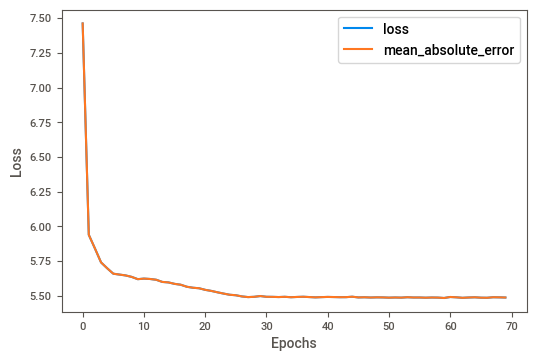

In [168]:
# Evaluating on test data
model_3.evaluate(test_dataset)

In [169]:
#Setting random seed to guarantee reproducibility
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(1)
])

#Compile model
model_2.compile(
    loss = tf.losses.mae,
    optimizer = tf.optimizers.SGD(),
    metrics = tf.metrics.mae
)

#Create early stopping to avoid unnecessary epochs
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='mean_absolute_error', mode = 'min',patience=10)
#Fit model

history_2 = model_2.fit(training_dataset,epochs = 100,callbacks=[es])

 1/99 [..............................] - ETA: 5s - loss: 10.6757 - mean_absolute_error: 10.6757

47/99 [=============>................] - ETA: 0s - loss: 5.1244 - mean_absolute_error: 5.1244  

94/99 [===========================>..] - ETA: 0s - loss: 5.7524 - mean_absolute_error: 5.7524

99/99 [==============================] - 0s 1ms/step - loss: 5.7785 - mean_absolute_error: 5.7785


[5.778472423553467, 5.77847146987915]

### Model 3

Increasing the complexity of the model didn't seem to impact the results, neither is giving more epochs since the early stopping callback was triggered.



In this model we'll keep the changes made on model 2 and we'll tune the optimizer hyperparameters.

In [170]:
#Setting random seed to guarantee reproducibility
tf.random.set_seed(42)
tf.debugging.set_log_device_placement(True)

# Create model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(1)
])

#Compile model
model_3.compile(
    loss = tf.losses.mae,
    optimizer = tf.optimizers.SGD(learning_rate=0.001, momentum=0),
    metrics = tf.metrics.mae
)

#Create early stopping to avoid unnecessary epochs
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='mean_absolute_error', mode = 'min',patience=10)
#Fit model

history_3 = model_3.fit(training_dataset,epochs = 1000,callbacks=[es])

Epoch 1/1000
391/391 [==============================] - 0s 1ms/step - loss: 5.4159 - mean_absolute_error: 5.4159


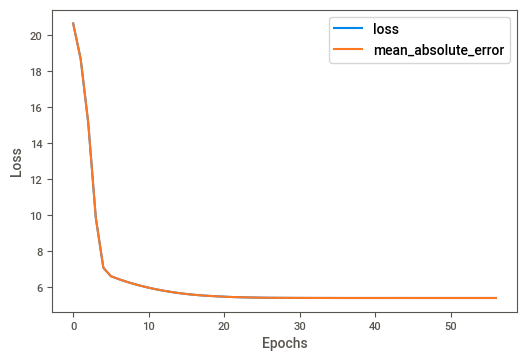

In [171]:
# Plotting Loss Curve
plt = pd.DataFrame(history_2.history).plot(xlabel = 'Epochs',ylabel = 'Loss')


In [172]:
# Evaluating on test data
model_2.evaluate(test_dataset)

 1/99 [..............................] - ETA: 4s - loss: 11.0372 - mean_absolute_error: 11.0372

62/99 [=================>............] - ETA: 0s - loss: 5.4904 - mean_absolute_error: 5.4904  

99/99 [==============================] - 0s 817us/step - loss: 5.6994 - mean_absolute_error: 5.6994


[5.699378490447998, 5.699378490447998]